# <p style="border:3px solid DodgerBlue;text-align:center;font-size:100%;">ВВЕДЕНИЕ</p>
<div class="alert alert-info" role="alert">
    
<center> <img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Booking.com_logo2.png" style="width:368px;height:81px;"> 
    
### КАКОЙ КЕЙС РЕШАЕМ?

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.
    
<center>
    <b>Описание данных</b>
    
    
<table >
   <tr>
    <th>Признак</th>
    <th>Описание</th>
  </tr>
  
   <tr>
    <td>hotel_address</td>
    <td>адрес отеля</td>
  </tr>
    
   <tr>
    <td>additional_number_of_scoring</td>
    <td>количество оценок без отзывов</td>
  </tr> 
    
  <tr>
    <td>review_date</td>
    <td>дата отзыва</td>
  </tr>
    
  <tr>
    <td>average_score</td>
    <td>средний балл отеля</td>
  </tr>
    
   <tr>
    <td>hotel_name</td>
    <td>название</td>
  </tr>
    
   <tr>
    <td>reviewer_nationality</td>
    <td>гражданство рецензента</td>
  </tr>
    
   <tr>
    <td>negative_review </td>
    <td>негативный отзыв</td>
  </tr> 
   
   <tr>
    <td>review_total_negative_word_counts </td>
    <td>число слов в негативном отзыве</td>
  </tr>  
    
   <tr>
    <td>total_number_of_reviews </td>
    <td>общее число отзывов на странице отеля</td>
  </tr>  
    
   <tr>
    <td>positive_review</td>
    <td>позитивный отзыв</td>
  </tr> 
    
   <tr>
    <td>review_total_positive_word_counts</td>
    <td>число слов в позитивном отзыве</td>
  </tr> 
    
  <tr>
    <td>total_number_of_reviews_reviewer_has_given</td>
    <td>общее число отзывов рецензента на площадке</td>
  </tr> 
    
   <tr>
    <td>reviewer_score</td>
    <td>оценка данная рецензентом отелю</td>
  </tr> 
    
   <tr>
    <td>tags</td>
    <td>теги </td>
  </tr> 
    
   <tr>
    <td>days_since_review</td>
    <td>дней с момента публикации отзыва</td>
  </tr> 
    
   <tr>
    <td>lat</td>
    <td>координата по широте</td>
  </tr> 
    
   <tr>
    <td>lng</td>
    <td>координата по долготе</td>
  </tr> 
    
</table>
    
</div>

<a id = '0'></a>
<p style = "font-size : 30px; color : white ; text-align : center; background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>Содержание</strong></p> 

* <a href ="#1">1. Исследование данных</a>
* <a href ="#2">2. Проектирование признаков</a>
  * <a href ="#2.1">2.1 Географическое расположение</a>
  * <a href ="#2.2">2.2 Анализ дат (review_date)</a>
  * <a href ="#2.3">2.3 Анализ тегов (tags)</a>
  * <a href ="#2.4">2.4 Информация о рецензенте</a>
  * <a href ="#2.5">2.5 Обработка отзывов</a>
* <a href ="#3">3. Отбор признаков</a>
* <a href ="#4">4. Обучение моделей</a>
  * <a href ="#4.1">4.1 RandomForestRegressor</a>
  * <a href ="#4.2">4.2 LightGBM</a>
  * <a href ="#4.3">4.3 CatBoostRegressor</a>
* <a href ="#5">5. Финал</a>


#### Загрузим наш инструментарий

In [1]:
%%capture

!pip install Afinn
!pip install nltk[twitter] 
!pip install seaborn
!pip install textblob
!pip install -U sklearn
!pip install geopy
!pip install catboost
!pip install lightgbm

# Стандартные библиотеки для работы с таблицами и вычислениями.
import numpy as np
import pandas as pd

# Инструменты визуализации.
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотека для кодировки признаков и счетчик хешируемых объектов.
import category_encoders as ce
from collections import Counter

# Инструменты для работы с геоданными.
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.extra.rate_limiter import RateLimiter

# NLP инструментарий.
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon', quiet=True)
nltk.download('popular', quiet=True)
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn

# Метрики и ножницы для рботы с выборками.
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, chi2

# Модели.
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgb

Изменим параметры вывода данных для датафреймов.

In [2]:
# Снимем ограничение на количество выводимых символов.
pd.set_option('display.max_colwidth', None)
# Установим лимит на число выводимых рядов.
pd.set_option('display.max_rows', 50)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

Загрузим датасеты и сабмишн.

In [3]:
# DATA_DIR = '/kaggle/input/sf-booking/'
# EXTRA_DATA_DIR = '/kaggle/input/dataset/datasets/'
# EXTRA_DATA_DIR_OTHER = '/kaggle/input/dataset/datasets/Other/'

RANDOM_SEED = 42
# df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # Датасет для обучения.
# df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # Датасет для предсказания.
# sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # Сабмишн.

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

<a id='1'></a>
<p style = "background-color : dodgerblue; border-radius: 5px 5px; padding : 10px"><strong>

# 1. Исследование данных
</strong></p>

<a href ="#0">Вернуться к содержанию.</a>

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [6]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


Как видим, в тестовом датасете у нас отсутствует признак ***reviewer_score***, т.к. его-то нам и нужно будет предсказать. Следующий интересный момент: оценки в сабмишн, разумеется, привязаны к конкретным индексам отзывов в тестовом датасете, поэтому нам при обработке данных и в процессе создания новых признаков нужно будет сберечь их порядок и состав.

Далее обратим внимание на то, что и в трейне, и в тесте единственными признаками с пропусками являются сведения о геоданных - их мы устраним после объединения датасетов в один датафрейм: это нужно, чтобы обеспечить в них однародность данных, обработав оба за один заход. В целом, датасеты в плане пропусков у нас довольно аккуратны.

In [7]:
# Найдем дубликаты...
all_columns = list(df_train.columns)
mask_dupl = df_train.duplicated(subset=all_columns) 
data_duplicates = df_train[mask_dupl]
print(f'Количество найденных дубликатов: {data_duplicates.shape[0]}')
# ...и удалим их.
df_train.drop_duplicates(inplace=True,ignore_index=True)

Количество найденных дубликатов: 307


Теперь мы можем объединить датасеты.

In [8]:
# Создадим новый признак-маркер для различения тестовых и треннировочных строк.
df_train['sample'] = 1 # Промаркируем единицами строки из трейна.
df_test['sample'] = 0 # Нулями - строки теста.
df_test['reviewer_score'] = 0 # В тесте у нас нет значения reviewer_score,
# т.к. его-то мы и должны будем предсказать, поэтому мы создадим этот признак
# в этом датасете и просто приравняем его значения к нулю.

# Обьединяем датасеты.
rvws = pd.concat([df_train, df_test], ignore_index = True)

---

#### Простой взгляд на проблему

Однако, пока мы не ушли слишком далеко, есть, пожалуй, смысл в том, чтобы взглянуть на распределение соотношений средневыборочных оценок отелей для имеющихся в трейне отзывов и итоговых рейтингов. Это может помочь нам оценить свои собственные возможности предсказать истинный рейтинг.

In [9]:
# Создадим новый датафрейм, содержащий агрегированные данные об отзывах и рейтингах.
train_grpb = pd.DataFrame(df_train.groupby(['hotel_name',])['reviewer_score'].count())
train_grpb.rename(columns = {'reviewer_score': 'rvwrs_num'}, inplace=True)
train_grpb['ttl_rvws_num'] = df_train.groupby(['hotel_name'])['total_number_of_reviews'].mean().astype('int64')
train_grpb['rn_of_trn'] = round(train_grpb['rvwrs_num'] / train_grpb['ttl_rvws_num'], 3)
train_grpb['reviewers_mean_score'] = df_train.groupby(['hotel_name'])['reviewer_score'].mean()
train_grpb['average_score'] = df_train.groupby(['hotel_name'])['average_score'].mean()
train_grpb['rs_of_as'] = round(train_grpb['reviewers_mean_score'] / train_grpb['average_score'], 3)
train_grpb.head(3)

,rvwrs_num,ttl_rvws_num,rn_of_trn,reviewers_mean_score,average_score,rs_of_as
hotel_name,,,,,,
11 Cadogan Gardens,110,393,0.280,8.988182,8.7,1.033
1K Hotel,111,663,0.167,7.932432,7.7,1.030
25hours Hotel beim MuseumsQuartier,505,4324,0.117,8.998614,8.8,1.023


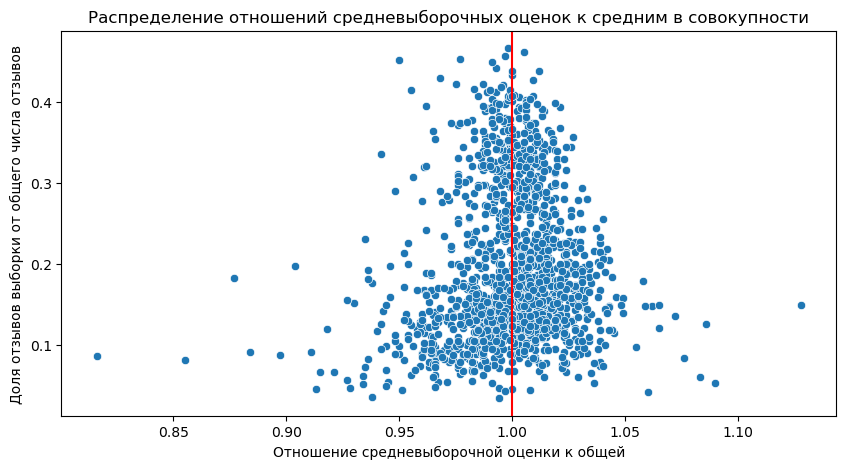

In [10]:
fig = plt.figure(figsize=(10, 5))

scatterplot = sns.scatterplot(data=train_grpb, x='rs_of_as', y='rn_of_trn')
plt.axvline(x=1, color='r')
scatterplot.set_title('Распределение отношений средневыборочных оценок к средним в совокупности')
scatterplot.set_xlabel('Отношение средневыборочной оценки к общей')
scatterplot.set_ylabel('Доля отзывов выборки от общего числа отзывов');

In [11]:
print(f"Число якобы переоцененных отелей:       {train_grpb[train_grpb['rs_of_as'] < 1].shape[0]}",
      f"Число якобы адекватно оцененных отелей: {train_grpb[train_grpb['rs_of_as'] == 1].shape[0]}",
      f"Число якобы недооцененных отелей:       {train_grpb[train_grpb['rs_of_as'] > 1].shape[0]}", sep='\n')

Число якобы переоцененных отелей:       676
Число якобы адекватно оцененных отелей: 37
Число якобы недооцененных отелей:       779


Вот здесь мы можем позволить себе вольное предсказание: для 676 отелей истинный рейтинг должен быть пересмотрен в нижнюю сторону; а, стало быть, для 779 - в верхнюю; и лишь отзывы 37 отелей оправдывают их итоговые рейтинги. На самом же деле средневыборочные значения могут даже сильно отличаться от средних в генеральной совокупности, и происходить это может чаще в том случае, когда первая составляет очень малую долю от второй (риск ошибки нерепрезентативности выборки нарастает); и чем больше размер выборки, тем ближе отношение средних оценок подходит к единице. Собственно, это мы и видим в нашем графике, где вертикальная шкала отражает информацию об относительной величине выборки: распределение точек, более беспорядочное внизу, наверху становится уже: там расположены средневыборочные оценки для сопоставимых с главной совокупностью коллекций.

Разумеется, мы ничего здесь не сможем сказать о том, накручивают ли себе рейтинг те отели, выборочные средние оценки которых ушли влево, хоть и велик соблазн: это был бы весьма примитивный анализ на фоне имеющихся у нас аналитических возможностей, способных давать порой совсем контринтуитивные заключения об исследуемых объектах.

---

Мы объединили тест и трейн, значит теперь можем расправиться с пропусками в геоданных.

In [12]:
print('Размерность получившегося датасета:', f'Число строк:    {rvws.shape[0]}',
      f'Число столбцов: {rvws.shape[1]}\n', sep='\n')

# Т.к. координаты широты и долготы друг без друга мало информативны,
# сделаем предположение, что пропуски в данных по этим признакам приходятся на
# одни и те же отели.
print(f'Число ненулевых записей ({rvws[rvws.lng.notna() & rvws.lat.notna()].shape[0]})',
      f'= Общее число записей ({rvws.shape[0]})', 
      f'- Число строк с пропусками в обоих признаках ({rvws[(rvws.lng.isna()) & (rvws.lat.isna())].shape[0]})',
      f'= {rvws.shape[0] - rvws[(rvws.lng.isna()) & (rvws.lat.isna())].shape[0]}')

Размерность получившегося датасета:
Число строк:    515431
Число столбцов: 18

Число ненулевых записей (512163) = Общее число записей (515431) - Число строк с пропусками в обоих признаках (3268) = 512163


Как видим, наше предположение оказалось верным.

In [13]:
# Сгрупируем по отелям и посмотрим у каких отелей отсутствуют геоданные.
htls_without_gdt = rvws[rvws.lng.isna()].groupby(by = ['hotel_address','hotel_name']).\
count().iloc[:,0].to_frame().reset_index()
htls_without_gdt.rename(columns = {'additional_number_of_scoring': 'cnt'}, inplace=True)
htls_without_gdt

,hotel_address,hotel_name,cnt
0,20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37
1,23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55
2,4 rue de la P pini re 8th arr 75008 Paris France,Maison Albar Hotel Paris Op ra Diamond,290
3,Bail n 4 6 Eixample 08010 Barcelona Spain,NH Collection Barcelona Podium,146
4,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,City Hotel Deutschmeister,93
5,Hasenauerstra e 12 19 D bling 1190 Vienna Austria,Hotel Park Villa,61
6,Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,Fleming s Selection Hotel Wien City,658
7,Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,Cordial Theaterhotel Wien,57
8,Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,Hotel Daniel Vienna,245
9,Paragonstra e 1 11 Simmering 1110 Vienna Austria,Roomz Vienna,49


Отелей без геоданных оказалось не так уж и много. Можно попробовать определить их координаты вручную ;)

In [14]:
htls_without_gdt[['lat','lng']] = 0
htls_without_gdt.loc[0,['lat','lng']] = [48.8399957, 2.3070823]
htls_without_gdt.loc[1,['lat','lng']] = [48.8889127, 2.3309643]
htls_without_gdt.loc[2,['lat','lng']] = [48.8753208, 2.3212033]
htls_without_gdt.loc[3,['lat','lng']] = [41.391552, 2.1757053]
htls_without_gdt.loc[4,['lat','lng']] = [48.2208555, 16.3644228]
htls_without_gdt.loc[5,['lat','lng']] = [48.233592, 16.3434781]
htls_without_gdt.loc[6,['lat','lng']] = [48.2094054, 16.3512565]
htls_without_gdt.loc[7,['lat','lng']] = [48.2095525, 16.3492746]
htls_without_gdt.loc[8,['lat','lng']] = [48.1888183, 16.381591]
htls_without_gdt.loc[9,['lat','lng']] = [48.1868142, 16.418528]
htls_without_gdt.loc[10,['lat','lng']] = [41.3749946, 2.1102353]
htls_without_gdt.loc[11,['lat','lng']] = [48.219573, 16.2834034]
htls_without_gdt.loc[12,['lat','lng']] = [41.3832425, 2.1607609]
htls_without_gdt.loc[13,['lat','lng']] = [48.2458909, 16.3397395]
htls_without_gdt.loc[14,['lat','lng']] = [48.2135906, 16.3777195]
htls_without_gdt.loc[15,['lat','lng']] = [48.2168032, 16.357717]
htls_without_gdt.loc[16,['lat','lng']] = [48.220414, 16.3536299]
htls_without_gdt.set_index('hotel_address', inplace=True)
htls_without_gdt.head()

,hotel_name,cnt,lat,lng
hotel_address,,,,
20 Rue De La Ga t 14th arr 75014 Paris France,Mercure Paris Gare Montparnasse,37,48.839996,2.307082
23 Rue Damr mont 18th arr 75018 Paris France,Holiday Inn Paris Montmartre,55,48.888913,2.330964
4 rue de la P pini re 8th arr 75008 Paris France,Maison Albar Hotel Paris Op ra Diamond,290,48.875321,2.321203
Bail n 4 6 Eixample 08010 Barcelona Spain,NH Collection Barcelona Podium,146,41.391552,2.175705
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,City Hotel Deutschmeister,93,48.220855,16.364423


Здесь можем сразу обратить внимание на то, что в адресах отелей из Австрии названия улиц содержат в себе пробелы: это, видимо, произошло из-за того, что исходные данные в ходе транспортировки претерпели некоторые преобразования из-за несоответствия систем кодирования символов исходника и посредника. Т.е. адреса были внесены в базу на разных языках. Это обстоятельство немного осложнит нам работу с адресами, в частности трудности будут с тем, что касается способа получения сведений об улицах, на которых отели расположены.

In [15]:
# Перезапишем геоданные в датасете.
for x in htls_without_gdt.index:
    rvws.loc[rvws[rvws['hotel_address'] == x].index, 'lat'] = htls_without_gdt.loc[x, 'lat']
    rvws.loc[rvws[rvws['hotel_address'] == x].index, 'lng'] = htls_without_gdt.loc[x, 'lng']

In [16]:
rvws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

С пропусками мы разобрались.

<a id = '2'></a>

<p style = "background-color : dodgerblue; border-radius: 5px 5px; padding : 10px"><strong>

# 2. Проектирование признаков (Feature Engineering)

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

Выведем описательную статистику для признаков типа object - с ними-то нам и предстоит поработать больше всего.

In [17]:
rvws.describe(include='object')

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515431,515431,515431,515431,515431,515431,515431,515431
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",1 days
freq,4789,2584,4789,245165,127816,35924,5101,2584


И сразу бросается в глаза несоответствие числа адресов отелей и названий: под одним именем у нас числятся два отеля. В этой паре признаков адрес представляет собой более уникальный признак. Из него мы в дальнейшем получим сведения о стране, городе, почтовом индексе и районе, где расположен отель. Из названий можно вытащить сведения, характеризующие отель: конкретные слова либо их число могут что-то да значить и оказывать влияние на оценку клиента.

Из даты отзывов мы получим сведения об их сезонном распределении.

Из гражданства рецензентов мы можем получить косвенные сведения о том, насколько непревычной и новой в культурном плане может быть для них сервис отеля.

Теги содержат в себе немаловажную информацию об отелях, мнении рецензентов о них и условиях приобретения последними своего потребительского опыта.

***days_since_review***, пожалуй, самый бесполезный признак для нашей задачи. Однако это еще предстоит проверить.

Совсем другое дело - сами тексты отзывов. Тут одназначно придется провести семантический анализ. Вообще, как-либо относящиеся к содержанию рецензий признаки очень важны и будут сильно влиять на эффективность предсказаний: это очевидно хотя бы потому, что людям свойственно пытаться передать эмоции наиболее простым для себя из предложенных видов способом: своими словами.

<a id = '2.1'></a>

<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

## 2.1 Географическое расположение

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

In [18]:
# Выведем несколько адресов.
rvws['hotel_address'][5:61:5]

5                                           Via Mecenate 121 20138 Milan Italy
10                                   Molenwerf 1 1014 AG Amsterdam Netherlands
15                                    Caspe 103 Eixample 08013 Barcelona Spain
20                     20 Upper Ground Southwark London SE1 9PD United Kingdom
25                         K rntner Ring 8 01 Innere Stadt 1010 Vienna Austria
30                       Karspeldreef 2 Zuidoost 1101 CJ Amsterdam Netherlands
35                 Via Fatebenefratelli 21 Milan City Center 20121 Milan Italy
40                             Pallars 121 125 Sant Mart 08018 Barcelona Spain
45                      Rotenturmstra e 15 01 Innere Stadt 1010 Vienna Austria
50                        Sancho de vila 32 34 Sant Mart 08018 Barcelona Spain
55                    92 Southampton Row Camden London WC1B 4BH United Kingdom
60    Prins Hendrikkade 33 Amsterdam City Center 1012 TM Amsterdam Netherlands
Name: hotel_address, dtype: object

Первыми в адресах стоят сведения либо об улицах, либо о номере дома (лондонский вариант). Далее в некоторых случаях идет название района - иногда этих сведений нет. Затем индекс, после которого - город и страна.

In [19]:
# Создадим признак - страна отеля. Это, разумеется, будет еще один
# категориальный признак. Потом мы его перекодируем.
rvws['hotel_country'] = rvws['hotel_address'].apply(lambda x: x.split()[-1])

# С Британией не все так просто.
rvws.loc[rvws['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'

# Посмотрим, отели каких стран у нас представлены.
rvws['hotel_country'].value_counts()

United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: hotel_country, dtype: int64

In [20]:
# Аналогичный городской признак.
rvws['hotel_city'] = rvws['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])

# Посмортим на города.
rvws['hotel_city'].value_counts()

London       262300
Barcelona     60149
Paris         59626
Amsterdam     57212
Vienna        38938
Milan         37206
Name: hotel_city, dtype: int64

Удивительно, на каждую страну у нас приходится всего один город - это значит, что признаки будут дублировать друг друга. В дальнейшем нам, скорее всего, придется ограничиться включением в итоговый датасет лишь одного из них.

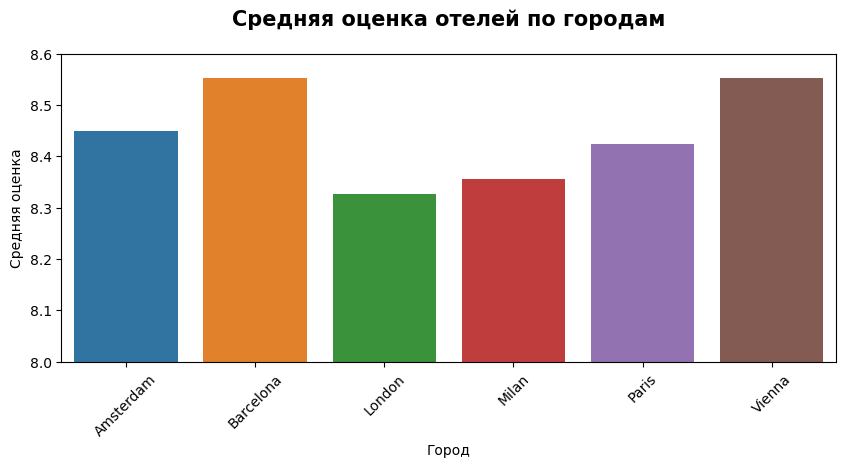

In [21]:
# Cоздадим сводную таблицу для дальнейшей визуализации.
cities_pt = pd.pivot_table(data=rvws[rvws['sample']==1], index='hotel_city', values='reviewer_score', aggfunc=['mean'])

figure, ax = plt.subplots(figsize=(10,4))
ax.set_ylim(8, 8.6);
ax.tick_params(axis='x', rotation=45)
sns.barplot(x=cities_pt.index, y=cities_pt[('mean', 'reviewer_score')]);
ax.set_xlabel('Город')
ax.set_ylabel('Средняя оценка')
plt.title('Средняя оценка отелей по городам', fontsize=15, fontweight='bold', pad=20);

Наибольшая средняя оценка отелей наблюдается в Барселоне и Вене. В Лондоне - наименьшая, но и отзывов о лондонских отелях у нас больше всего. Однако возможно, нам все-таки удалось выявить значимый фактор, влияющий на оценку клиентов.

In [22]:
%%time

# Создадим датафрейм для городов.
cities = pd.DataFrame(rvws.hotel_city.unique(), columns=['city'])  # city_coors

# Воспользуемся библиотекой для работы с геокоординатами.
geolocator = Nominatim(user_agent="AV_Kaggle")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Создадим признаки с коормдинатами городских центров.
cities['lat'], cities['lng'] = zip(*cities.city.apply(lambda x: geolocator.geocode(x)[1]))

# Превратим наш датафрейм в словарь с геоданными городов.
city_gdt_dict = cities.set_index('city').to_dict('dict')

# Создадим в датафрейме отзывов новые признаки для координат городских центров.
rvws['center_lat'] = rvws['hotel_city'].map(city_gdt_dict['lat'])
rvws['center_lng'] = rvws['hotel_city'].map(city_gdt_dict['lng'])

# И рассчитаем расстояние в км между отелями и центрами городов.
rvws['from_h_to_c'] = rvws.apply(lambda x: geodesic((x.lat,x.lng), (x.center_lat, x.center_lng)).kilometers, axis = 1)

Wall time: 1min 4s


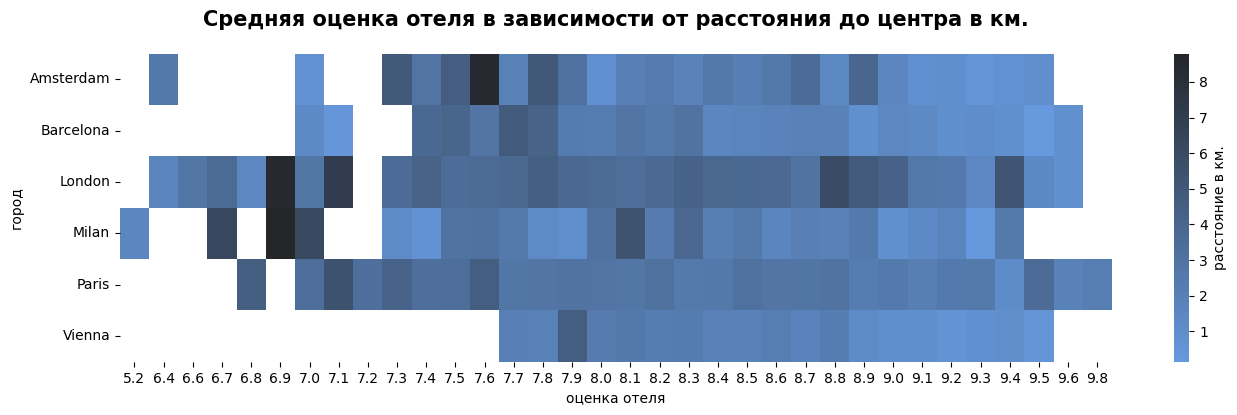

In [23]:
# Cоздадим сводную таблицу для дальнейшей визуализации.
pivot_distance = rvws[rvws['sample'] == 1].pivot_table( values='from_h_to_c', columns='average_score', index='hotel_city')

fig, ax = plt.subplots(figsize=(16,4))
cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)
heatmap = sns.heatmap(data=pivot_distance, cmap=cmap,
                      cbar_kws={'label': 'расстояние в км.'})
heatmap.set_title('Средняя оценка отеля в зависимости от расстояния до центра в км.',
                  fontsize=15, fontweight='bold', pad=20)
heatmap.set_xlabel('оценка отеля')
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='y', rotation=0)
heatmap.set_ylabel('город');

Здесь мы можем увидеть, что качество сервиса отелей в Лондоне, например, менее, чем в прочих городах, зависит от расстояния до центра. И все же, в целом, такая зависимость, как мы и ожидали, наблюдается: чем дальше от центра, тем хуже оценка.

In [24]:
# Закодируем hotel_address - этот признак является уникальным идентификатором отеля.
rvws['hotel_address'] = rvws['hotel_address'].astype('category')
rvws['ha_code'] = rvws['hotel_address'].cat.codes

# Закодируем hotel_city.
city_encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True)
city_name_bin = city_encoder.fit_transform(rvws['hotel_city'])
rvws = pd.concat([rvws, city_name_bin], axis=1)

# Удалим лишние признаки.
rvws.drop(['hotel_city', 'lat', 'lng', 'hotel_country',
           'center_lat', 'center_lng', 'hotel_address'], axis=1, inplace=True)

<a id = '2.2'></a>

<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

## 2.2 Работа с датами

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

In [25]:
# Сперва изменим тип представленных в столбце данных. 
rvws['review_date'] = pd.to_datetime(rvws['review_date'])

Полагаю, мы не совершим ошибки, если скажем, что деятельность отелей сильно зависит от фактора сезонности. И это обстоятельство может сильно влиять на оценку клиентом предоставелнного ему сервиса. В признаке даты отзыва нас мало интересует год сам по себе или месяц сам по себе, и уж точно не интересует день, т.к. день публикации отзыва, скорее всего, не является одним из дней проведенных рецензентом в отеле. Нам нужен признак, отражающий фактор сезонности.

In [26]:
# И этот признак - период.
rvws['review_period'] = rvws['review_date'].dt.to_period('M')

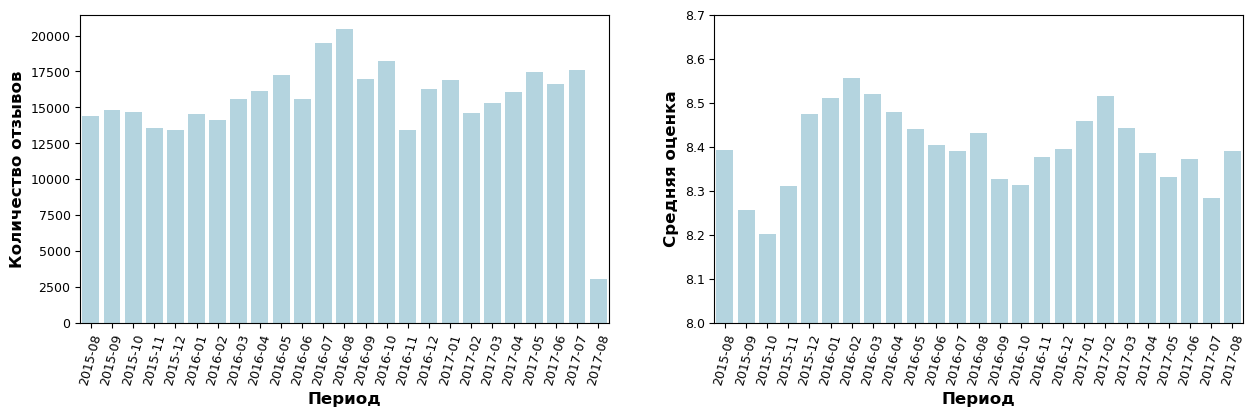

In [27]:
# Визуализируем зависимости количества отзывов и средних оценок от сезона.
period = rvws[rvws['sample']==1].pivot_table(values='reviewer_score', index='review_period', aggfunc=['mean', 'count'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x=period.index, y=period[('count', 'reviewer_score')], ax=ax1, color='lightblue')
ax1.set_ylabel('Количество отзывов', fontweight = 600, fontsize = 12)
ax1.tick_params(axis='x', rotation=75)
ax1.set_xlabel('Период', fontweight = 600, fontsize = 12)
ax1.tick_params(axis='both', which='major', labelsize=9)
sns.barplot(x=period.index, y=period[('mean', 'reviewer_score')], ax=ax2, color='lightblue')
ax2.set_ylabel('Средняя оценка', fontweight = 600, fontsize = 12);
ax2.tick_params(axis='x', rotation=75)
ax2.set_xlabel('Период', fontweight = 600, fontsize = 12)
ax2.tick_params(axis='both', which='major', labelsize=9)
plt.ylim(8, 8.7);

На этих графиках мы и правда можем наблюдать некоторое циклоподобие распределений количества отзывов и средних оценок. Значит, время года имеет значение и должно быть учтено моделью.

In [28]:
# Следовательно, нам потребуется перекодировать значения этого признака.
# Для этого мы сперва создадим словарь со всеми значениями: значения подобраны так,
# чтобы уменьшить ощутимо относительное расстояние между их величинами.
period_dict = {'2015-08': 1001, '2015-09': 1002, '2015-10': 1003, '2015-11': 1004, '2015-12': 1005,
               '2016-01': 1006, '2016-02': 1007, '2016-03': 1008, '2016-04': 1009, '2016-05': 1010,
               '2016-06': 1011, '2016-07': 1012, '2016-08': 1013, '2016-09': 1014, '2016-10': 1015,
               '2016-11': 1016, '2016-12': 1017, '2017-01': 1018, '2017-02': 1019, '2017-03': 1020,
               '2017-04': 1021, '2017-05': 1022, '2017-06': 1023, '2017-07': 1024, '2017-08': 1025}
# А затем с помощью лямбда-функции просто их заменим.
rvws['review_period'] = rvws['review_period'].apply(lambda x: period_dict[x.strftime('%Y-%m')])

In [29]:
# Удалим обработанный признак.
rvws.drop(['review_date'], axis=1, inplace=True)

In [30]:
# Признак days_since_review имеет отношение к разряду сущностей, рассматриваемых в этом разделе.
# И, хоть его ценность сомнительна для целей нашего исследования, мы все же попытаемся выжить
# что-нибудь полезное и из него.
rvws['days_since_review'] = rvws['days_since_review'].apply(lambda x: int(x.split()[0]))

<a id = '2.3'></a>

<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

## 2.3 Обработка тегов

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

Сперва посчитаем число уникальных тегов.

In [31]:
# Напишем функцию, преобразующую строковые значения в ячейках столбца
# с тегами и возвращающую их в форме списка.
def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(" ', ' ")
    return res

rvws['tags'] = rvws['tags'].apply(rev_func)

print(f"Число уникальных тегов: {len(rvws['tags'].explode().unique())}")

Число уникальных тегов: 2428


In [32]:
# Посчитаем и взглянем на топовые теги.
tags_cntr = Counter(rvws['tags'].explode())
tags = pd.Series(tags_cntr)
tags.sort_values(ascending=0)[:15]

Leisure trip                      417538
Submitted from a mobile device    307470
Couple                            252128
Stayed 1 night                    193568
Stayed 2 nights                   133850
Solo traveler                     108476
Stayed 3 nights                    95761
Business trip                      82884
Group                              65361
Family with young children         60989
Stayed 4 nights                    47777
Double Room                        35207
Standard Double Room               32247
Superior Double Room               31361
Family with older children         26334
dtype: int64

In [33]:
# Также взглянем на некоторые коллекций тегов.
rvws['tags'][:500001:50000]

0                        [Leisure trip, Couple, Studio Suite, Stayed 2 nights, Submitted from a mobile device]
50000              [Leisure trip, Couple, Deluxe Single Room, Stayed 2 nights, Submitted from a mobile device]
100000               [Leisure trip, Couple, Deluxe King Room, Stayed 2 nights, Submitted from a mobile device]
150000              [Leisure trip, Couple, Large Double Room, Stayed 2 nights, Submitted from a mobile device]
200000                           [Solo traveler, Double Room, Stayed 2 nights, Submitted from a mobile device]
250000                                   [Business trip, Solo traveler, Standard Single Room, Stayed 4 nights]
300000    [Leisure trip, Solo traveler, Standard Double Room, Stayed 4 nights, Submitted from a mobile device]
350000                  [Leisure trip, Couple, Deluxe Double, Stayed 2 nights, Submitted from a mobile device]
400000                                       [Business trip, Solo traveler, Cosy Single Room, Stayed 3 nights]
4

Как видим, теги можно разделить на несколько классов:
 * По типу поездки: Leisure trip, Business trip. Указывается не во всех случаях, однако мы можем допустить, что командировка      чаще всего указывается явно: это было бы удобно для создания нового бинарного признака ***is_btrip***.
 * По составу заселяющихся в номер: Couple, Solo traveler, Group, Family with young children, Family with older children,
   Travelers with friends. Для отображения этого фактора мы создадим ранговый признак ***company***, целочисленные значения        которого будут характеризовать численность заселяющихся: 1 - для соло, 2 - для пары, 3 - для группы и путешественников с друзьями, 4 - для семей.
 * По типу снимаемого номера: здесь имеется сложная классификация - по числу комнат и статусу помещения. Оценить эти характеристики номеров я собираюсь с помощью системы награждения баллами: начисляю строке с тегом некоторый бал за наличие в нем определенных маркерных слов. Пожалуй, это наиболее субьективно определенный признак - называться он будет ***room_rating***.
 * По числу проведенных в номере ночей: признак ***nights*** будет содержать простое численное отражение соответствующего тега.
 * И снова бинарный признак ***smd_from_mob***: отправлена ли рецензия с помощью телефона.

In [34]:
# Создадим определяющий тип поездки признак и заполним его с помощью лямбда-функции.
rvws['is_btrip'] = rvws['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)

# Напишем функцию для определения состава заселяющихся в номер.
def comp_checker(line: list) -> int:
    if 'Solo traveler' in line:
        return 1
    if 'Couple' in line:
        return 2
    if 'Group' in line or 'Travelers with friends' in line:
        return 3
    if 'Family with young children' in line or 'Family with older children' in line:
        return 4
# И применим ее для заполнения соответствующего признака.
rvws['company'] = rvws['tags'].apply(comp_checker)

# Потребовалось создать два словаря, т.к. из-за состава тегов часто приходится иметь дело
# с комбинациями определений, что усложняет процесс учета всех из них.
evals_dict1 = {'Guest': 1, 'Studio': 1, 'Small': -0.25, 'Standart': 0.5, 'Standard': 0.5, 'Basic': 0.5, 'Club': 1,
              'Comfort': 0.5, 'Classic': 0.5, 'Superior': 0.75, 'Deluxe': 1.25, 'Executive': 1.5, 'Suite': 2.25,
              'Quadruple': 2, 'Junior Suite': 2.5, 'Family': 1.25, 'Compact': 0.25, 'Economy': 0.25, 'Large': 0.5}
evals_dict2 = {'King': 2.25, 'Queen': 2.25, 'Single': 1, 'Triple': 1.75, 'King Family': 1.75,  'Luxury': 1,
               'Modern': 0.25}
# Напишем функцию для распределения баллов.
def room_checker(line: list) -> float:
    rat = 0
    if len(line) <= 2:
        return 0.25
    if line[0] in ('Leisure trip', 'Business trip'):
        trg_els = line[2].split()
    else:
        trg_els = line[1].split()
    if 'Double' in trg_els or 'Twin' in trg_els or '2' in trg_els:
        rat += 1.25
    for word1 in trg_els:
        if word1 in evals_dict1:
            rat += evals_dict1[word1]
    for word2 in trg_els:
        if word2 in evals_dict2:
            rat += evals_dict2[word2]
    if rat  > 0.25:
        return rat
    else:
        return 0.25
# Применим ее для заполнения соответствующего признака.
rvws['room_rating'] = rvws['tags'].apply(room_checker)

# Функция для получения числа проведенных ночей из тега.
def nights_counter(line: list) -> int:
    for tag in line:
        if 'Stayed' in tag:
            return round(int(tag.split()[1]))
    return 1
# Применим ее для заполнения соответствующего признака.
rvws['nights'] = rvws['tags'].apply(nights_counter)

# И снова бинарный признак - отправил ли рецензент свой отзыв через телефон.
rvws['smd_from_mob'] = rvws['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

Попробуем визуализировать содержимое новых признаков.

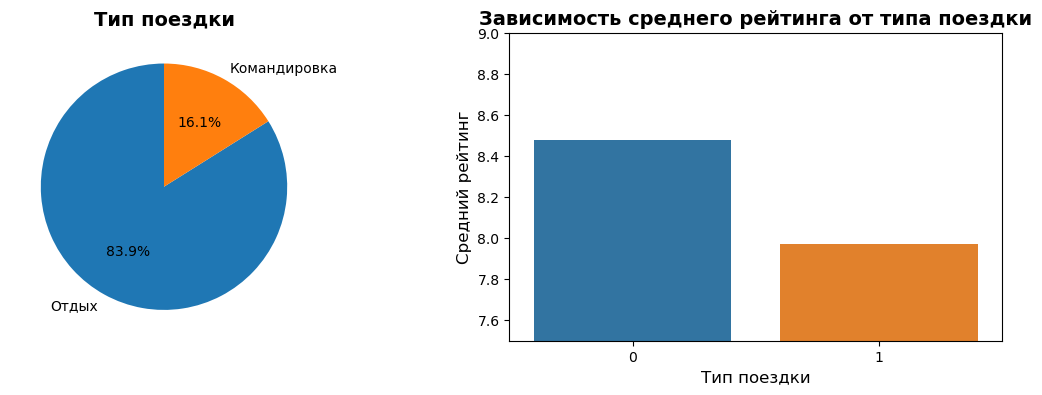

In [35]:
trip_types_pivot = pd.pivot_table(data=rvws[rvws['sample']==1],
    index='is_btrip', values='reviewer_score', aggfunc=['mean'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

trip_types_count = rvws['is_btrip'].value_counts()
ax1.pie(trip_types_count, labels=['Отдых', 'Командировка'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Тип поездки', weight='bold', fontsize=14)

sns.barplot(x=trip_types_pivot.index, y=trip_types_pivot[('mean', 'reviewer_score')], ax=ax2)
ax2.set_title('Зависимость среднего рейтинга от типа поездки', weight='bold', fontsize=14)
ax2.set_ylabel('Средний рейтинг', fontsize=12)
ax2.set_xlabel('Тип поездки', fontsize=12)
plt.ylim(7.5, 9);

Судя по получившемуся графику, тип поездки все ж в среднем влият на оценку рецензентов. Возможно, это связано с тем, что те, кто заселяется в отель в рамках командировки, часто имеют более специфические потребности или острее реагируют на недостатки; либо же они просто тратят меньше времени на заполнение анкеты отзыва.

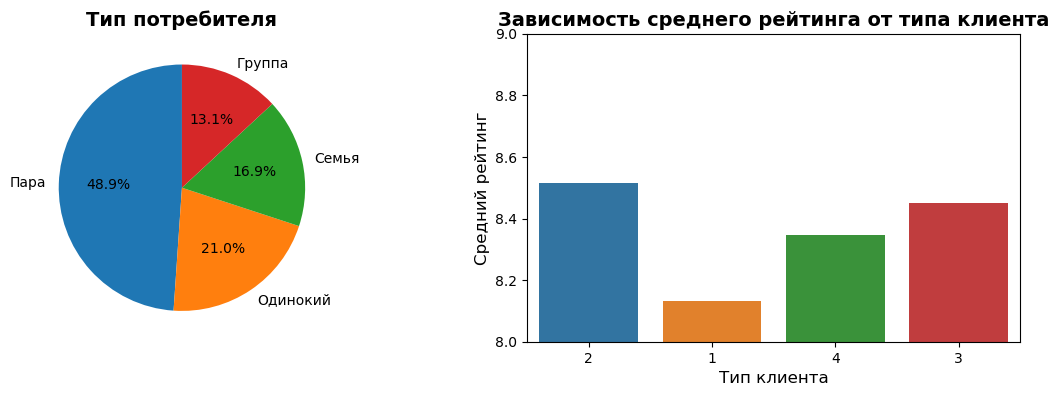

In [36]:
comp_type_pivot = pd.pivot_table(data=rvws[rvws['sample']==1], 
    index='company', values='reviewer_score', aggfunc=['mean'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

com_types_count = rvws['company'].value_counts()
ax1.pie(com_types_count, labels=['Пара', 'Одинокий', 'Семья', 'Группа'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Тип потребителя', weight='bold', fontsize=14)

sns.barplot(x=comp_type_pivot.index, y=comp_type_pivot[('mean', 'reviewer_score')], ax=ax2, order=[2,1,4,3])
ax2.set_title('Зависимость среднего рейтинга от типа клиента', weight='bold', fontsize=14)
ax2.set_ylabel('Средний рейтинг', fontsize=12)
ax2.set_xlabel('Тип клиента', fontsize=12)
plt.ylim(8, 9);

Тип клиента действительно может иметь заметное влияние на оценку. Сравнительно высокие баллы от пар, надо полагать, обязаны специфическому роду снисходительности людей, пребывающих в определенном психическом состоянии, что особенно заметно в сравнеии с категорией одиночек. Разумеется, причин такой разности может быть уйма, здесь мы только предполагаем. Также, например, относительное отставание средних оценок рецензентов с семьями можно попытаться объяснить чуть более высокой их требовательностью к сервису, связанной с вопросами ухода за детьми.

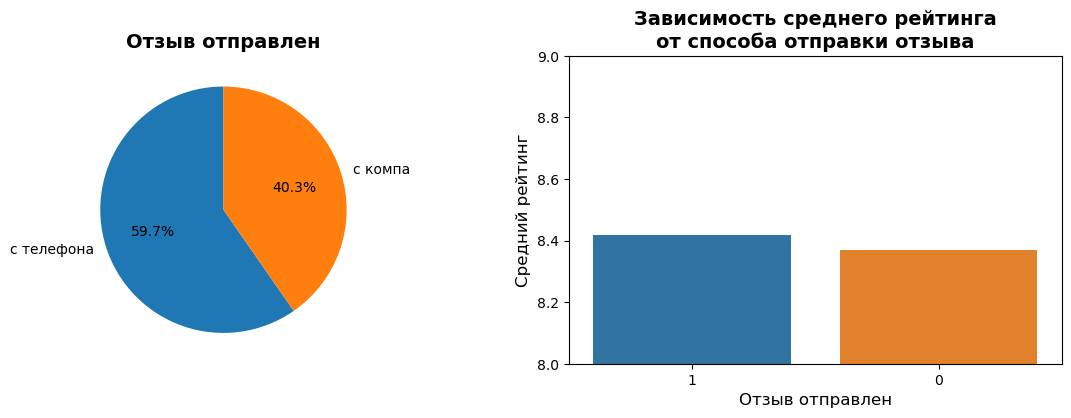

In [37]:
smd_from_mob_pivot = pd.pivot_table(data=rvws[rvws['sample']==1],
    index='smd_from_mob', values='reviewer_score', aggfunc=['mean'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

smd_type = rvws['smd_from_mob'].value_counts()
ax1.pie(smd_type, labels=['с телефона', 'с компа'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Отзыв отправлен', weight='bold', fontsize=14)

sns.barplot(x=smd_from_mob_pivot.index, y=smd_from_mob_pivot[('mean', 'reviewer_score')], ax=ax2, order=[1, 0])
ax2.set_title('Зависимость среднего рейтинга\nот способа отправки отзыва', weight='bold', fontsize=14)
ax2.set_ylabel('Средний рейтинг', fontsize=12)
ax2.set_xlabel('Отзыв отправлен', fontsize=12)
plt.ylim(8, 9);

Особенной разности нет. Рецензенты, оставлявшие отзывы не с мобильных устройств, в среднем чуть хуже оценивали отели: видимо потому, что процесс рецензирования за компьютером позволял тратить на себя больше времени.

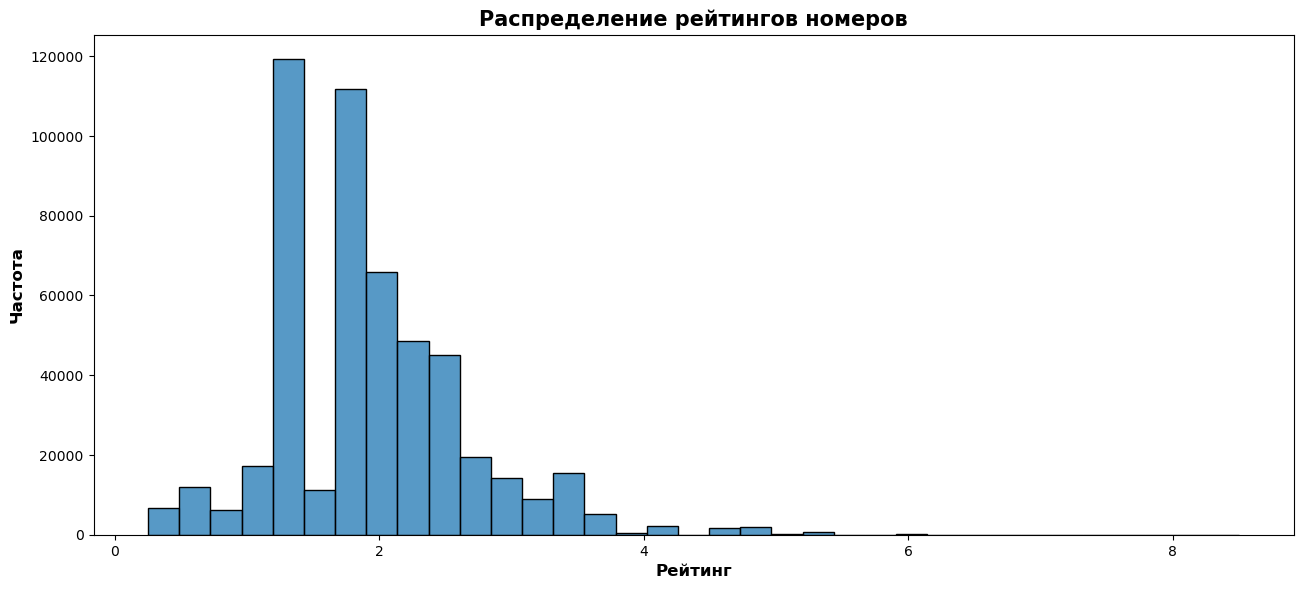

In [38]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_axes((1, 1, 1, 1))
sns.histplot(data=rvws, x='room_rating', bins=35)
ax.set_title('Распределение рейтингов номеров', fontweight ='bold', size=15)
ax.set_xlabel('Рейтинг', fontweight='bold', size=12)
ax.set_ylabel('Частота', fontweight='bold', size=12);

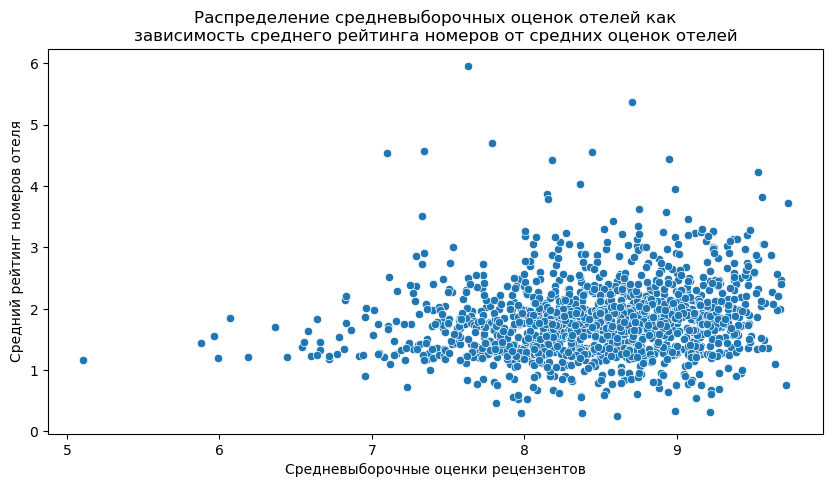

In [39]:
fig = plt.figure(figsize=(10, 5))

room_rat_pivot = pd.pivot_table(data=rvws[rvws['sample']==1],
    index='hotel_name', values=['reviewer_score', 'room_rating'], aggfunc=['mean'])

scatterplot = sns.scatterplot(data=room_rat_pivot, x=room_rat_pivot['mean']['reviewer_score'],
    y=room_rat_pivot['mean']['room_rating'])
scatterplot.set_title('''Распределение средневыборочных оценок отелей как
зависимость среднего рейтинга номеров от средних оценок отелей''')
scatterplot.set_xlabel('Средневыборочные оценки рецензентов')
scatterplot.set_ylabel('Средний рейтинг номеров отеля');

Вот здесь уже сложно увидеть какую-либо зависимость. Похоже, наша ручная оценка номеров испортила ценное содержание тегов, если, разумеется, оно там было. 

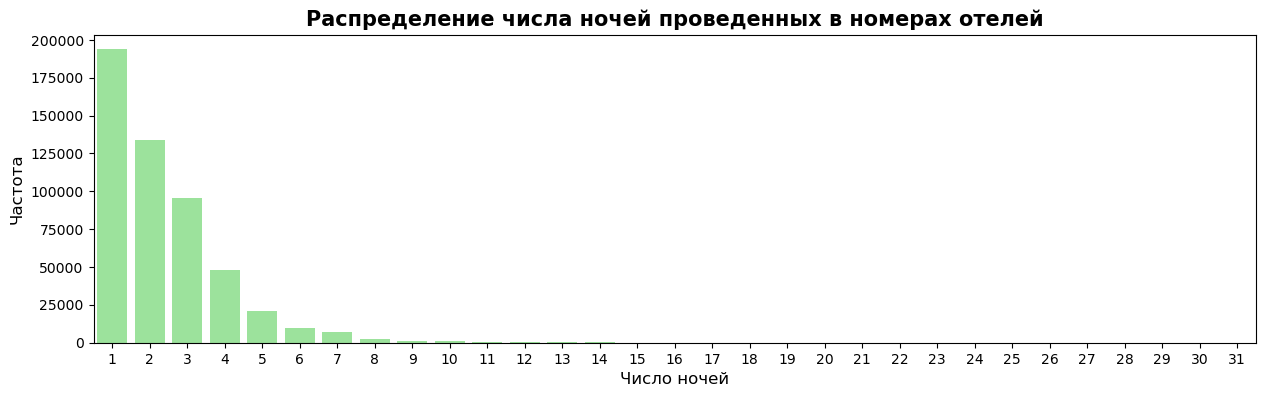

In [40]:
nights = rvws['nights'].value_counts()

fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(x=nights.index, y=nights, color='lightgreen')
ax.set_title('Распределение числа ночей проведенных в номерах отелей', fontweight ='bold', size=15)
ax.set_ylabel('Частота', fontsize = 12)
ax.set_xlabel('Число ночей', fontsize = 12);

Мы видим нелинейный, стремительный спад числа проведенных ночей. Были клиенты, жившие в отелях целый месяц.

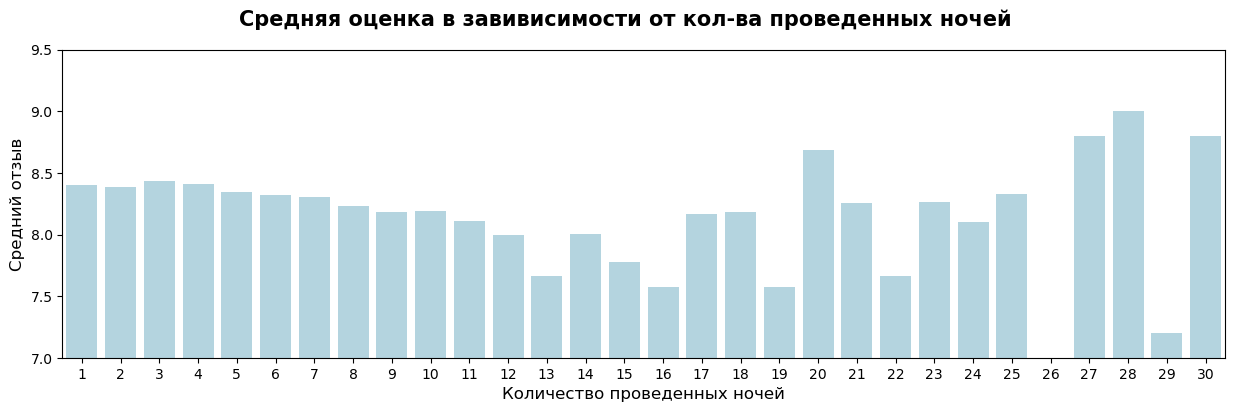

In [41]:
pivot_nights = pd.pivot_table(data=rvws[rvws['sample']==1],
    index='nights', values='reviewer_score', aggfunc=['mean'])

fig1, ax1 = plt.subplots(figsize=(15, 4))
plt.suptitle('Средняя оценка в завивисимости от кол-ва проведенных ночей', fontweight ='bold', size=15)
sns.barplot(x=pivot_nights.index, y=pivot_nights[('mean', 'reviewer_score')], color='lightblue')
plt.xlabel('Количество проведенных ночей', fontsize = 12)
plt.ylabel('Средний отзыв', fontsize = 12)
plt.ylim(7, 9.5);

Присутствует хорошо определяемая зависимость между средним балллом и количеством проведенных ночей - она прихоится на участок до 13: далее оценки рецензентов ведут себя почти хаотично. Хотя мы еще можем далее попробовать распознать некоторый восходящий тренд в оценках: это можно, наверное, объяснить тем, что вряд ли кто-то по собственной воле надолго оставался бы в отеле, который его не устраивает; но, разумеется, действительных причин может быть уйма, а количество таких случаев относительно ничтожно.

In [42]:
# Удалим обработанный признак.
rvws.drop(['tags'], axis=1, inplace=True)

<a id = '2.4'></a>

<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

## 2.4 Информация о рецензенте

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

In [43]:
# Посмотрим на общую картину по признаку гражданства.
rvws.reviewer_nationality.value_counts()

 United Kingdom               245165
 United States of America      35390
 Australia                     21663
 Ireland                       14820
 United Arab Emirates          10230
                               ...  
 Guinea                            1
 Tuvalu                            1
 Comoros                           1
 Anguilla                          1
 Cape Verde                        1
Name: reviewer_nationality, Length: 227, dtype: int64

Как видим, имеется довольно большой разброс значений: наши рецензенты являются выходцами 227 стран.

In [44]:
# Интересное значение.
rvws.reviewer_nationality.value_counts()[-165:-155]

 Estonia         757
 Jordan          756
 Lithuania       727
 Latvia          719
 Mexico          591
 Guernsey        543
                 523
 Argentina       516
 Isle of Man     405
 Gibraltar       380
Name: reviewer_nationality, dtype: int64

В некоторых ячейках столбца находятся пропуски.

In [45]:
# Выберем для визуализации часть датасета, представленную десятью
# наиболее распрастраненными гражданствами рецензентов.
top_10_nat_inds = rvws.reviewer_nationality.value_counts().nlargest(10).index
top_10_nat_df = rvws.copy()
top_10_nat_df['reviewer_nationality'] = top_10_nat_df['reviewer_nationality'].apply(
    lambda x:x if x in top_10_nat_inds else ' Other')
top_10_nat_df['reviewer_nationality'].value_counts(normalize=True) * 100

 United Kingdom               47.565048
 Other                        28.318242
 United States of America      6.866098
 Australia                     4.202890
 Ireland                       2.875264
 United Arab Emirates          1.984747
 Saudi Arabia                  1.735441
 Netherlands                   1.699937
 Switzerland                   1.682475
 Germany                       1.539682
 Canada                        1.530176
Name: reviewer_nationality, dtype: float64

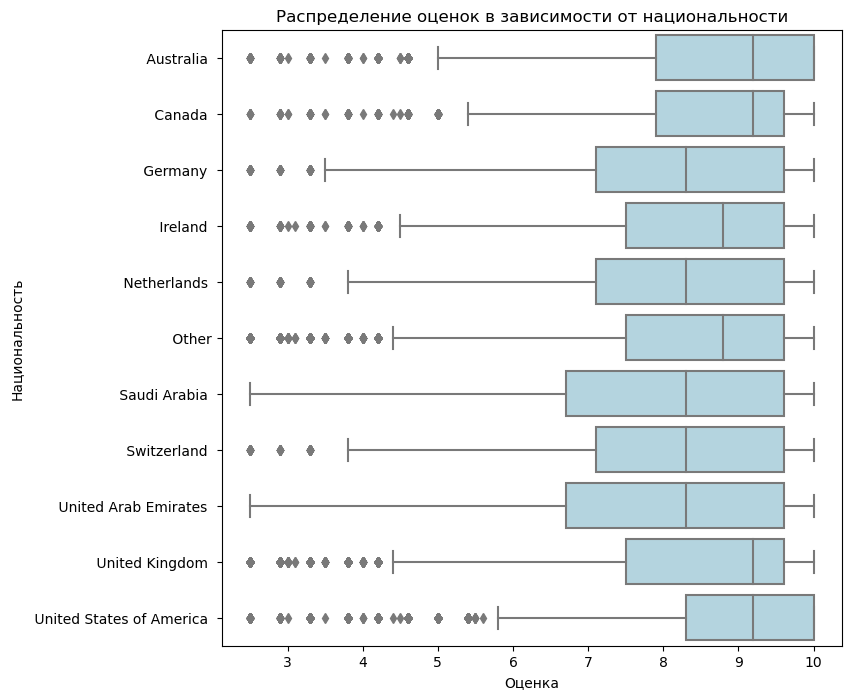

In [46]:
# Посмотрим зависит ли оценка от национальности.
fig, axes = plt.subplots(figsize=(8, 8))

# Построим график
nationality = sns.boxplot(
    data = top_10_nat_df[top_10_nat_df['sample'] == 1].sort_values(by='reviewer_nationality', ascending=True),
    y = 'reviewer_nationality', x = 'reviewer_score', color='lightblue')

# Зададим названия осей и заголовок.
nationality.set(xlabel='Оценка', ylabel='Национальность', title='Распределение оценок в зависимости от национальности');

Признак гражданства рецензентов, пожалуй, действительно имеет определенное значение, т.к. отражает некоторые аспекты культурных различий.

In [47]:
# Закодируем признак.
rvws['reviewer_nationality'] = rvws['reviewer_nationality'].astype('category')
rvws['rev_nat_te'] = ce.TargetEncoder(min_samples_leaf=20, smoothing=10).fit_transform(
        rvws['reviewer_nationality'], rvws['reviewer_score'])

# Удалим обработанный признак.
rvws.drop(['reviewer_nationality'], axis=1, inplace=True)

<a id = '2.5'></a>
<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

## 2.5 Обработка отзывов

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

В этом разделе нам предстоит заняться семантическим анализом текстов отзывов. Это самый важный раздел анализа датасета: здесь будет создано самое большое количество дополнительных признаков.

Семантический анализ текста машинными методами - это не самая тривиальная задача: применяемые нами анализаторы пока что не всегда видят наличие смысла там, где он есть, иногда видят смысл там, где его нет, или же распознают совсем не тот смысл, что подразумевается автором записи. Поэтому перед тем как отправить текст в модель, его нужно обработать.

In [48]:
print(list(rvws['negative_review'][5:10]), list(rvws['positive_review'][5:10]), sep='\n')

[' Nothing', ' Nothing it was lovely ', ' The communal areas are a bit soul less and the breakfast whilst very good is expensive But you can always use the cafe at the tram stop Elise I think for breakfast and late night drinks We did ', ' undergoing refurbishment no tea coffer in room room very small no ramp at entrance for wheeled suitcases no coffee available in lounge next morning early checkout at 11 00am', ' I advised it was for my husbands birthday and reception gave us a twin room when i booked a double I asked for little extras to be put in the room for his birthday and it was given too late and didnt make it special ']
[' Very nice hotel Price is excellent when compared to quality Very quiet Good food ', ' Very central location 2 minutes walk from Gloucester Rd tube station and 10 15 minutes walk from the museums Lots of restaurants and bars on the doorstep ', ' The location is good for transport links especially if you are a tram lover the number 2 stops two minutes away eas

И тут мы обнаруживаем, что кто-то уже поработал с текстами в ячейках и убрал все знаки препинания. А также тексты отзывов часто окружены пробелами - от них нужно будет избавиться.

In [49]:
# Избавляемся от лишних пробелов.
rvws['negative_review'] = rvws['negative_review'].apply(lambda x: x.strip())
rvws['positive_review'] = rvws['positive_review'].apply(lambda x: x.strip())

In [50]:
rvws['negative_review'].value_counts().reset_index().head(10)

,index,negative_review
0,No Negative,127816
1,Nothing,18525
2,nothing,2506
3,None,1166
4,N A,1060
5,,849
6,Nothing really,569
7,N a,520
8,All good,469
9,Small room,455


In [51]:
rvws['positive_review'].value_counts().reset_index().head(10)

,index,positive_review
0,No Positive,35924
1,Location,10128
2,Everything,2897
3,location,1733
4,Nothing,1466
5,Great location,1417
6,The location,1339
7,Good location,1202
8,Breakfast,664
9,Friendly staff,602


В ячейках обоих признаков имеются фразы, слова и даже аббревиатуры, которые можно классифицировать как высказывания об отсутствии суждений об отеле в соответствующей рубрике отзыва, например: 'No Negative', 'Nothing', 'None', 'N A', 'Nothing really', 'No Positive' и др. При более тщательном обзоре значений можно выявить даже фразы и слова с грамматическими ошибками или даже слова и фразы не на английском языке. Суть же в том, что модели семантических анализаторов, скорее всего, обнаружат и в этих случаях достаточный смысл для конкретной классификации. Поэтому мы, наверное, поступим не так уж неверно, если просто удалим эти значения из ячеек исследуемых признаков.

In [52]:
rvws[['negative_review', 'review_total_negative_word_counts']][:6]

,negative_review,review_total_negative_word_counts
0,Leaving,3
1,poor breakfast,3
2,No kettle in room,6
3,No Negative,0
4,Torn sheets,4
5,Nothing,2


Также признак-счетчик в датасете содержит неверное число слов в отзыве. После обработки текстов в последних, необходимо перерасчитать значения и для этого признака. Аналогично для позитивных отзывов.

In [53]:
# Составим список "обнуляемых" выражений для негативных отзывов.
neg_words_lst = ['No Negative', 'Nothing', 'None', 'N A', 'Nothing really', 'All good', 'No complaints', 'Nothing at all'
                 'Nothing to dislike', 'Nil', 'Can t think of anything', 'NA', 'No', 'Non', 'No thing', 'All ok', 'all good'
                 'No issues', 'No dislikes', 'Nada', 'Nothing bad', 'All great']
# Список выражений для позитивных отзывов.
pos_words_lst = ['No Positive', 'Nothing', 'None', 'N A', 'NA', 'No', 'Non']

# Заменяем на пустые строки значения признаков, присутствующие в списках выше.
rvws['negative_review'] = rvws['negative_review'].apply(lambda x: '' if x in neg_words_lst else x)
rvws['positive_review'] = rvws['positive_review'].apply(lambda x: '' if x in pos_words_lst else x)

# Подправим значения признаков в тех случаях, когда число слов в отзыве 
# не позволяет интерпретировать текст в ячейке как явное утверждение.
rvws['negative_review'] = rvws['negative_review'].apply(lambda x: 'bad is ' + x if 0 < len(x.split()) <= 2 else x)
rvws['positive_review'] = rvws['positive_review'].apply(lambda x: 'good is ' + x if 0 < len(x.split()) <= 2 else x)

# Пересчитаем значения счетчик-признаков.
rvws['review_total_negative_word_counts'] = rvws['negative_review'].apply(lambda x: len(x.split()))
rvws['review_total_positive_word_counts'] = rvws['positive_review'].apply(lambda x: len(x.split()))

С подготовительной частью мы закончили. Анализ текстов отзывов будет осуществлен с применением трех разных инструментов: модуль анализа тональности VADER из платформы NLTK; анализатор настроения текста Afinn; библиотека для обработки текстовых данных textblob: модуль textblob.sentiments содержит две реализации анализа тональности, по умолчаию - PatternAnalyzer (на основе библиотеки шаблонов), и опционально - NaiveBayesAnalyzer (классификатор NLTK, обученный на базе обзоров фильмов).

In [54]:
%%time

# Создадим два анализатора - на каждый вид отзыва свой.
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

rvws['neg_scores'] = rvws['negative_review'].apply(lambda x: sia_neg.polarity_scores(x))
rvws['pos_scores'] = rvws['positive_review'].apply(lambda x: sia_pos.polarity_scores(x))

# Сформируем две производные группы признаков на каждый вид отзыва.
rvws['n_rvw_sntmnts_neg'] = rvws['neg_scores'].apply(lambda x: x['neg'])
rvws['n_rvw_sntmnts_neu'] = rvws['neg_scores'].apply(lambda x: x['neu'])
rvws['n_rvw_sntmnts_pos'] = rvws['neg_scores'].apply(lambda x: x['pos'])
rvws['n_rvw_sntmnts_cmpnd'] = rvws['neg_scores'].apply(lambda x: x['compound'])

rvws['p_rvw_sntmnts_neg'] = rvws['pos_scores'].apply(lambda x: x['neg'])
rvws['p_rvw_sntmnts_neu'] = rvws['pos_scores'].apply(lambda x: x['neu'])
rvws['p_rvw_sntmnts_pos'] = rvws['pos_scores'].apply(lambda x: x['pos'])
rvws['p_rvw_sntmnts_cmpnd'] = rvws['pos_scores'].apply(lambda x: x['compound'])

Wall time: 1min 45s


In [55]:
%%time

# Аналогично создадим два afinn-анализитора.
afinn_neg = Afinn()
afinn_pos = Afinn()

# И отправим результаты анализа в ячейки двух новых соответствующих признака. 
rvws['neg_afinn_scores'] = rvws['negative_review'].apply(lambda x: afinn_neg.score(x))
rvws['pos_afinn_scores'] = rvws['positive_review'].apply(lambda x: afinn_pos.score(x))

Wall time: 4min 15s


In [56]:
%%time

tb = Blobber(analyzer=NaiveBayesAnalyzer())

# Создадим функцию для расчета тональности по методу NaiveBayesAnalyzer.
def analyzer_NBA_TB(x: str) -> tuple:
    blob = tb(x).sentiment
    return blob[1], blob[2]

# Создадим функцию для расчета тональности по методу PatternAnalyzer.
def analyzer_PA_TB(x: str) -> tuple:
    blob = TextBlob(x)
    return blob.sentiment_assessments.polarity

# Запустим работу функций над текстами отзывов и отправим параметры
# результатов в соответствующие признаки.
rvws['neg_nba_tb'] = rvws['negative_review'].apply(analyzer_NBA_TB)
rvws['pos_nba_tb'] = rvws['positive_review'].apply(analyzer_NBA_TB)
rvws['neg_pa_tb'] = rvws['negative_review'].apply(analyzer_PA_TB)
rvws['pos_pa_tb'] = rvws['positive_review'].apply(analyzer_PA_TB)

rvws['n_nba_tb_p_neg'] = rvws['neg_nba_tb'].apply(lambda x: x[1])
rvws['n_nba_tb_p_pos'] = rvws['neg_nba_tb'].apply(lambda x: x[0])
rvws['p_nba_tb_p_neg'] = rvws['pos_nba_tb'].apply(lambda x: x[1])
rvws['p_nba_tb_p_pos'] = rvws['pos_nba_tb'].apply(lambda x: x[0])

Wall time: 4min 33s


In [57]:
# Удалим обработанные признаки.
rvws.drop(['positive_review', 'negative_review', 'neg_scores', 'pos_scores',
           'neg_nba_tb', 'pos_nba_tb'], axis=1, inplace=True)

<a id = '3'></a>

<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

# 3 Отбор признаков

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

In [58]:
# Взглянем на получившуюся коллекцию признаков.
rvws.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   hotel_name                                  515431 non-null  object 
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   reviewer_score                              515431 non-null  float64
 8   days_since_review                           515431 non-null  int64  
 9   sample                                      515431 non-null  int64  
 

Остался всего один признак с типом object - ***hotel_name***. Он нам далее не понадобится.

In [59]:
rvws.drop(['hotel_name'], axis=1, inplace=True)

Разделим признаки для последующего их корреляционного анализа и оценки значимости.

In [60]:
# Числовые признаки.
nmrcl_ftrs = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews',
              'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review',
              'from_h_to_c', 'n_rvw_sntmnts_neg', 'n_rvw_sntmnts_neu', 'n_rvw_sntmnts_pos', 'n_rvw_sntmnts_cmpnd',
              'p_rvw_sntmnts_neg', 'p_rvw_sntmnts_neu', 'p_rvw_sntmnts_pos', 'p_rvw_sntmnts_cmpnd', 'neg_pa_tb',
              'pos_pa_tb', 'n_nba_tb_p_neg', 'n_nba_tb_p_pos', 'p_nba_tb_p_neg', 'p_nba_tb_p_pos', 'neg_afinn_scores',
              'pos_afinn_scores']

# Категориальные признаки.
ctgrcl_ftrs = ['average_score', 'ha_code', 'hotel_city_London', 'hotel_city_Paris', 'hotel_city_Amsterdam',
               'hotel_city_Milan', 'hotel_city_Vienna', 'hotel_city_Barcelona', 'review_period', 'is_btrip',
               'company', 'room_rating', 'nights', 'smd_from_mob', 'rev_nat_te']

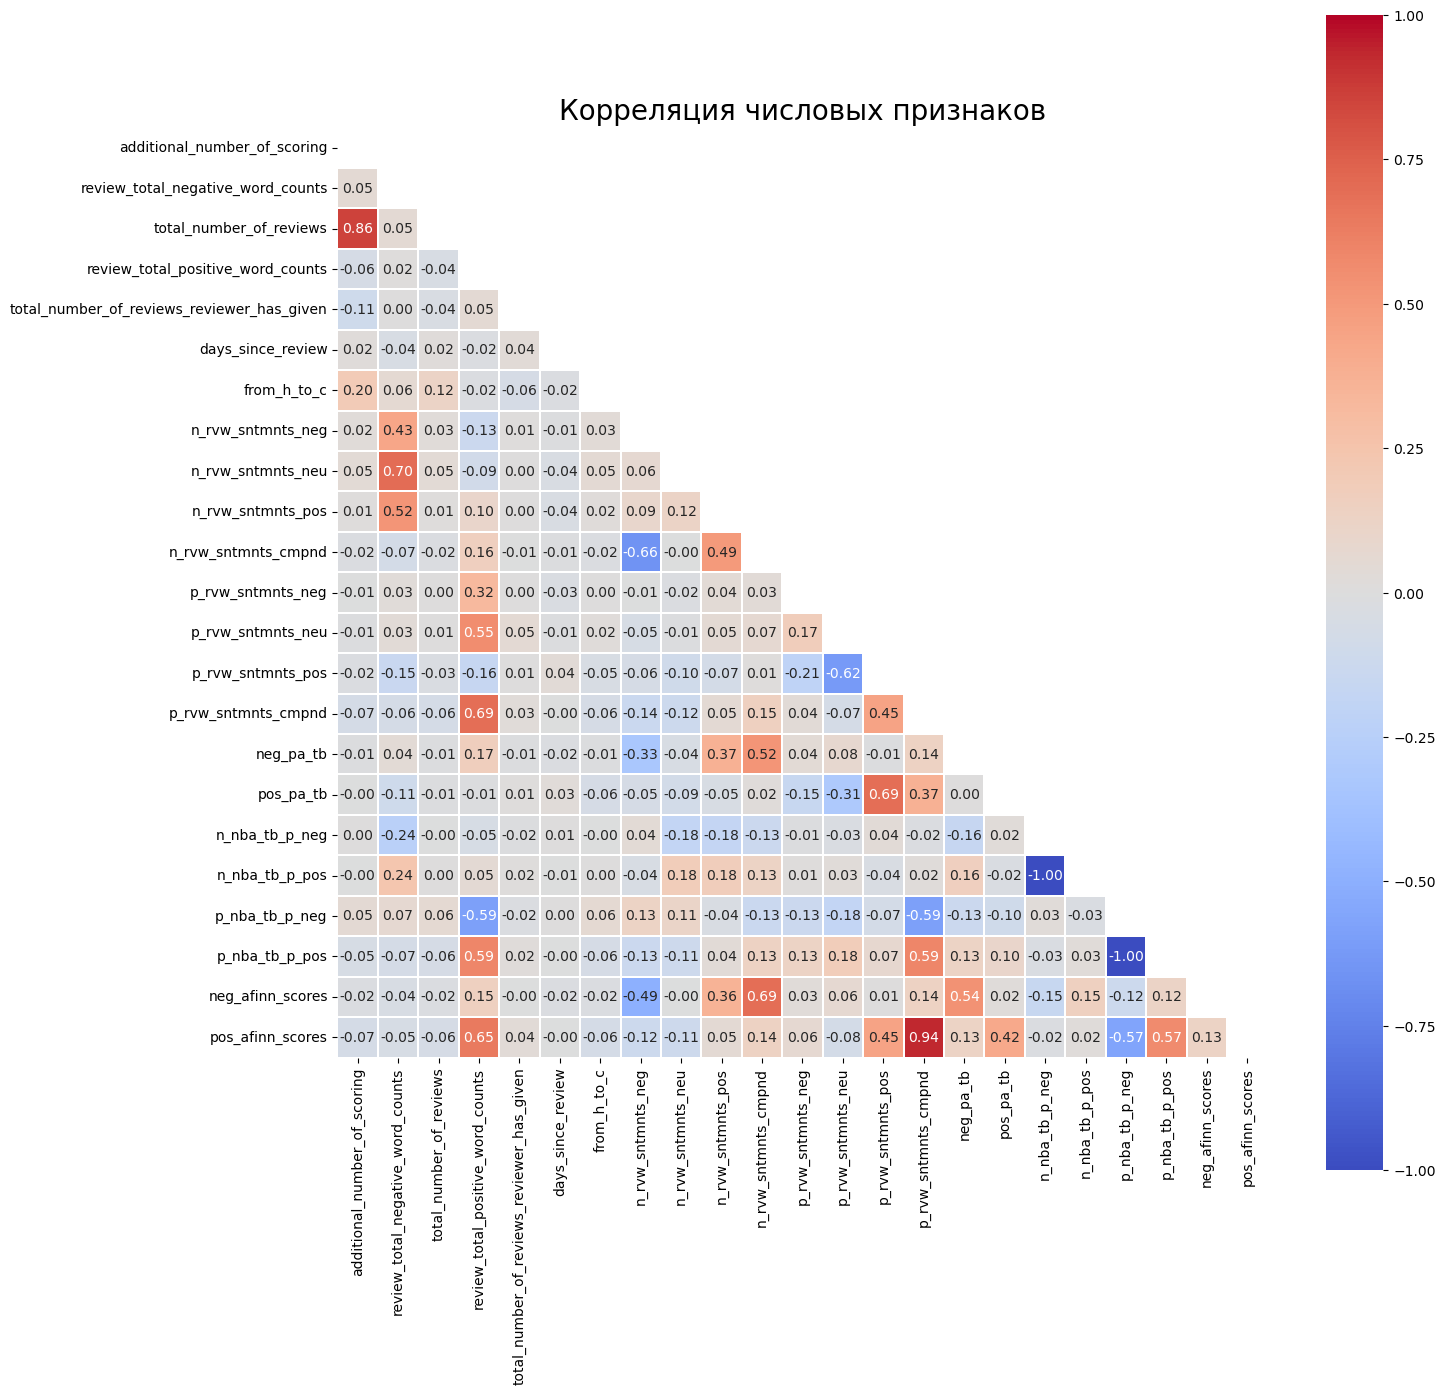

In [61]:
# Построим тепловую карту по матрице корреляций числовых признаков.
nmrcl_ftrs_corr = rvws[nmrcl_ftrs].corr(method='spearman')
plt.subplots(figsize=(15, 15))
matrix = np.triu(nmrcl_ftrs_corr)
sns.heatmap(nmrcl_ftrs_corr, vmin=-1, vmax=1, linewidth=0.1, cmap='coolwarm',
    annot = True, fmt='.2f', square=True, mask=matrix)
plt.title('Корреляция числовых признаков', fontsize=20);

Две пары признаков, полученные с помощью NaiveBayesAnalyzer библиотеки textblob дают максимальную отрицательную корреляцию, т.к. сумма значений внутри этих пар равна нулю. Необходимо удалить из этих пар те признаки, что оценивают обратную тональность текстов, расположенных в рубриках отзывов, предполагающих иной эмоциональный фон: т.е. нам лучше избавиться в этом случае от показателей, отражающих позитивную тональность в негативных отзывах и отрицательную тональность в положительных. Это признаки - ***n_nba_tb_p_pos*** и ***p_nba_tb_p_neg***.

In [62]:
rvws.drop(['n_nba_tb_p_pos', 'p_nba_tb_p_neg'], axis=1, inplace=True)
nmrcl_ftrs.remove('n_nba_tb_p_pos')
nmrcl_ftrs.remove('p_nba_tb_p_neg')

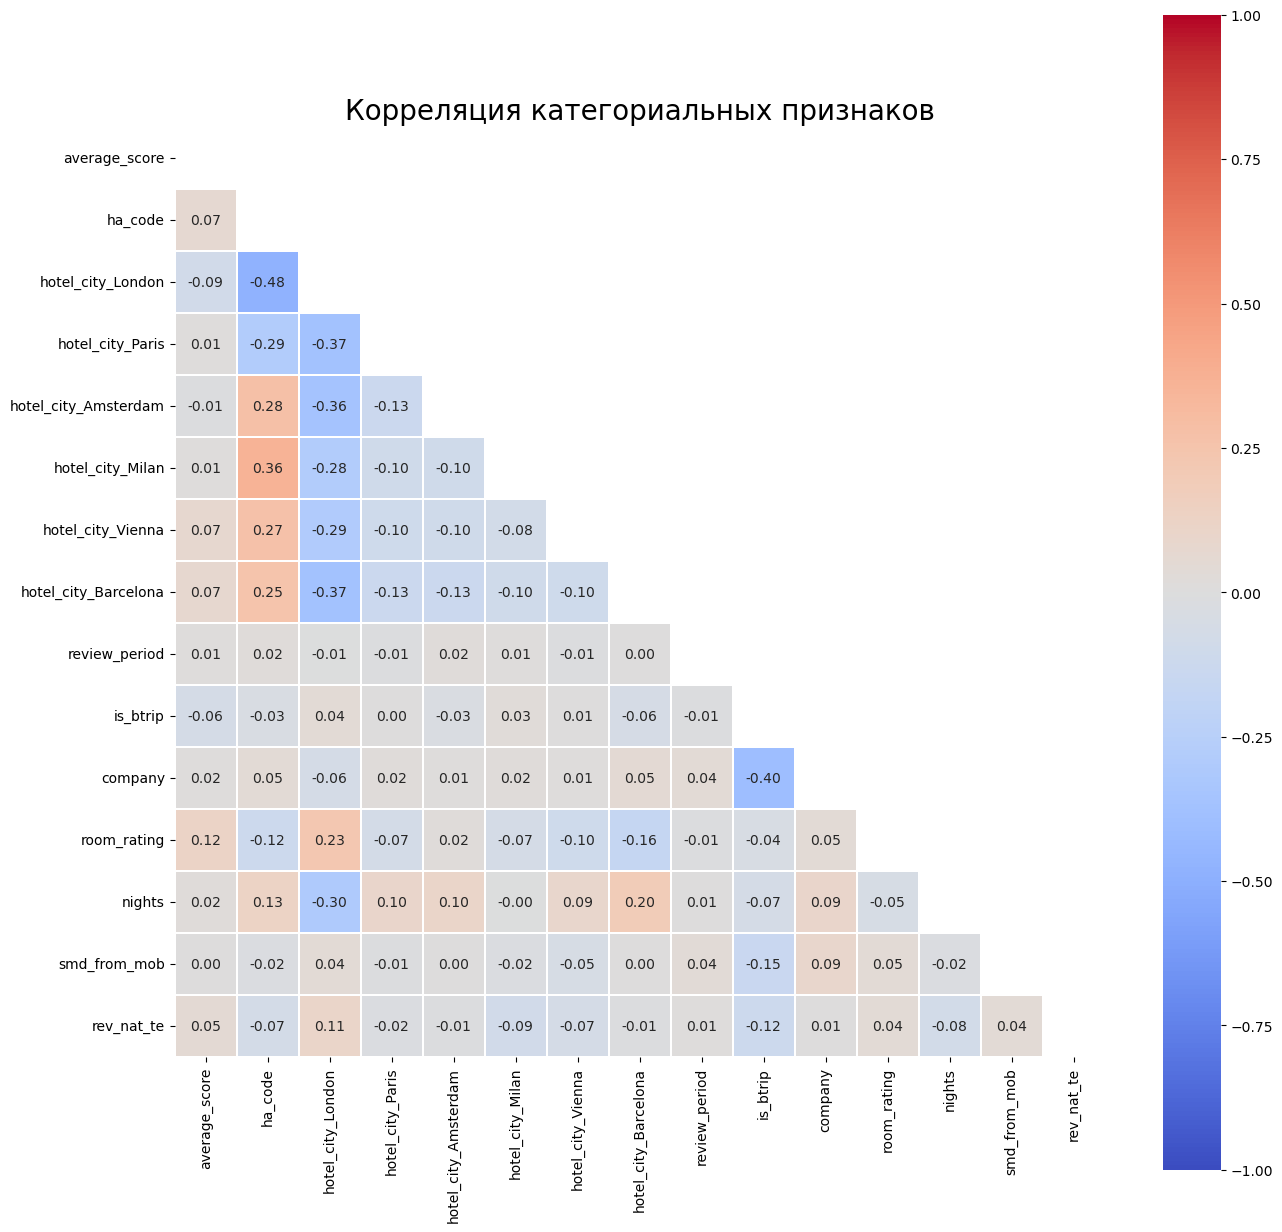

In [63]:
# Построим тепловую карту по матрице корреляций категориальных признаков.
ctgrcl_ftrs_corr = rvws[ctgrcl_ftrs].corr(method='spearman')
plt.subplots(figsize=(15, 15))
matrix = np.triu(ctgrcl_ftrs_corr)
sns.heatmap(ctgrcl_ftrs_corr, vmin=-1, vmax=1, linewidth=0.1, cmap='coolwarm',
    annot = True, fmt='.2f', square=True, mask=matrix)
plt.title('Корреляция категориальных признаков', fontsize=20);

In [64]:
# Разъединим наш датасет обратно на тестовую и трейновую части.
train_rvws = rvws.query('sample == 1').drop(['sample'], axis=1)
test_rvws = rvws.query('sample == 0').drop(['sample'], axis=1)
 
y = train_rvws.reviewer_score  # Наш таргет.
y = y.astype('int')        
X = train_rvws.drop(['reviewer_score'], axis=1)

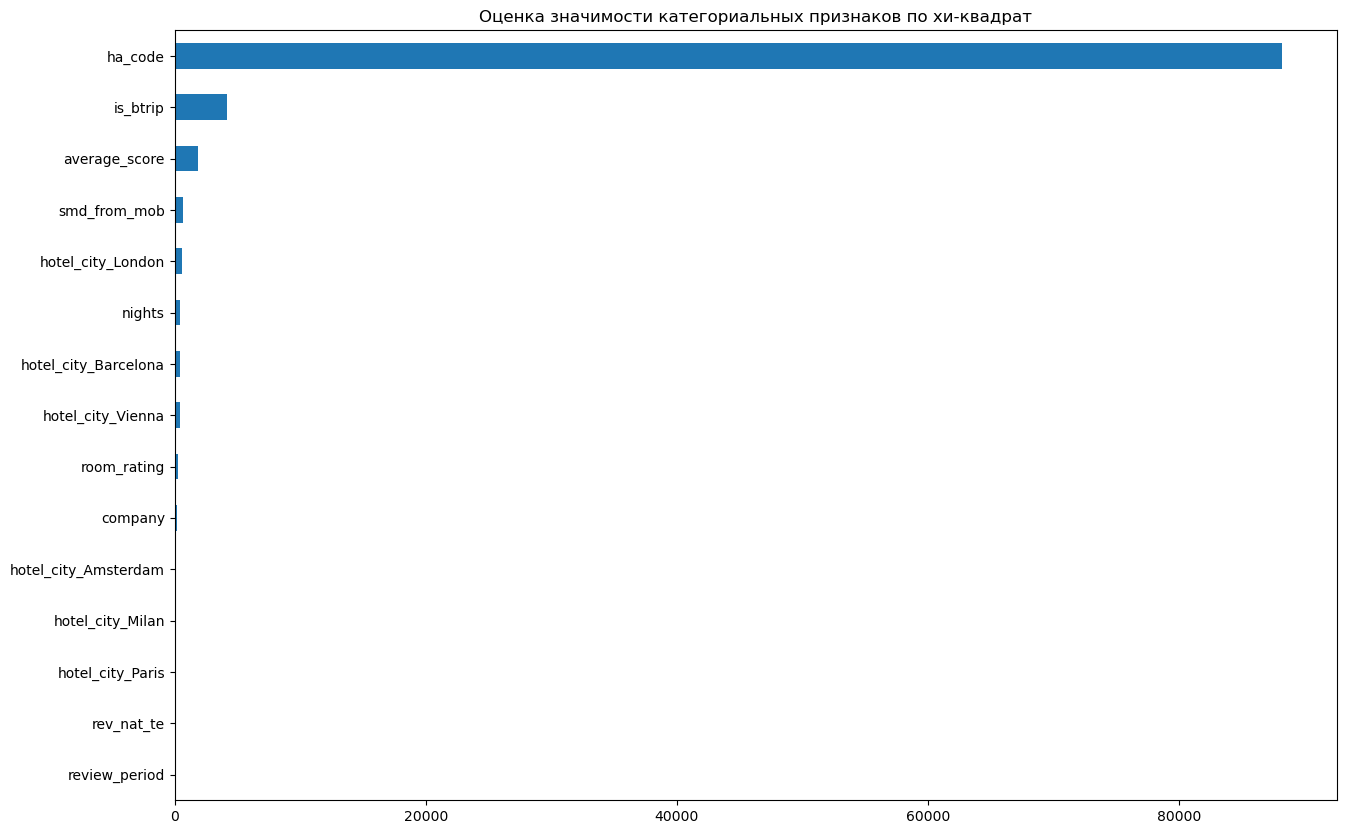

In [65]:
# Визуализируем результат анализа значимости по хи-квадрат.
rvws_chi2 = pd.Series(chi2(X[ctgrcl_ftrs], y)[0], index=ctgrcl_ftrs)
rvws_chi2.sort_values(inplace = True)
fig, ax = plt.subplots(figsize=(15, 10))
rvws_chi2.plot(kind = 'barh', title='Оценка значимости категориальных признаков по хи-квадрат');

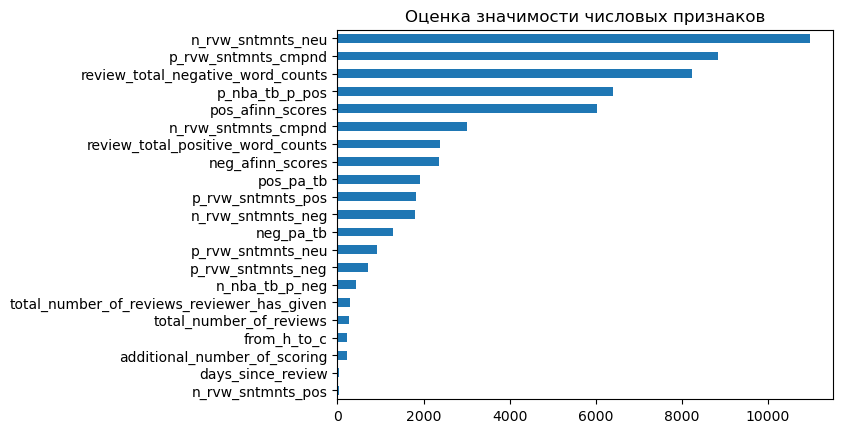

In [66]:
# Визуализируем результат анализа значимости числовых признаков.
rvws_fclss = pd.Series(f_classif(X[nmrcl_ftrs], y)[0], index=nmrcl_ftrs)
rvws_fclss.sort_values(inplace = True)
rvws_fclss.plot(kind = 'barh', title="Оценка значимости числовых признаков");

<a id = '4'></a>

<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

# 4 Обучение моделей

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

In [67]:
# Еще раз переназначим тест и трейн: ранее мы изменили тип y, чтобы провести тесты.
train_rvws = rvws.query('sample == 1').drop(['sample'], axis=1)
test_rvws = rvws.query('sample == 0').drop(['sample'], axis=1)

y = train_rvws.reviewer_score.values
X = train_rvws.drop(['reviewer_score'], axis=1)

# Разделим тестовые данные и выделим 20% на валидацию.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Проверяем размеры:
test_rvws.shape, train_rvws.shape, X.shape, X_train.shape, X_test.shape

((128935, 37), (386496, 37), (386496, 36), (309196, 36), (77300, 36))

<a id = '4.1'></a>
<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

## 4.1 RandomForestRegressor

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

Случайный лес — это ансамблевый метод, способный выполнять как задачи регрессии, так и задачи классификации с использованием нескольких деревьев решений и метода, называемого начальной загрузкой и агрегацией, также известного как бэггинг. Основная идея заключается в том, чтобы объединить несколько деревьев решений при определении конечного результата, а не полагаться на отдельные деревья решений.

In [68]:
# Создаём модель.
model_RFR = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [69]:
%%time

# Обучаем модель на тестовом наборе данных
model_RFR.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred_RFR = model_RFR.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


Wall time: 56.3 s


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished


In [70]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred_RFR))

MAPE: 0.8499723051808042


In [71]:
res_RFR = round(metrics.mean_absolute_percentage_error(y_test, y_pred_RFR) * 100, 4)
print('Результат MAPE:', res_RFR)

Результат MAPE: 12.144


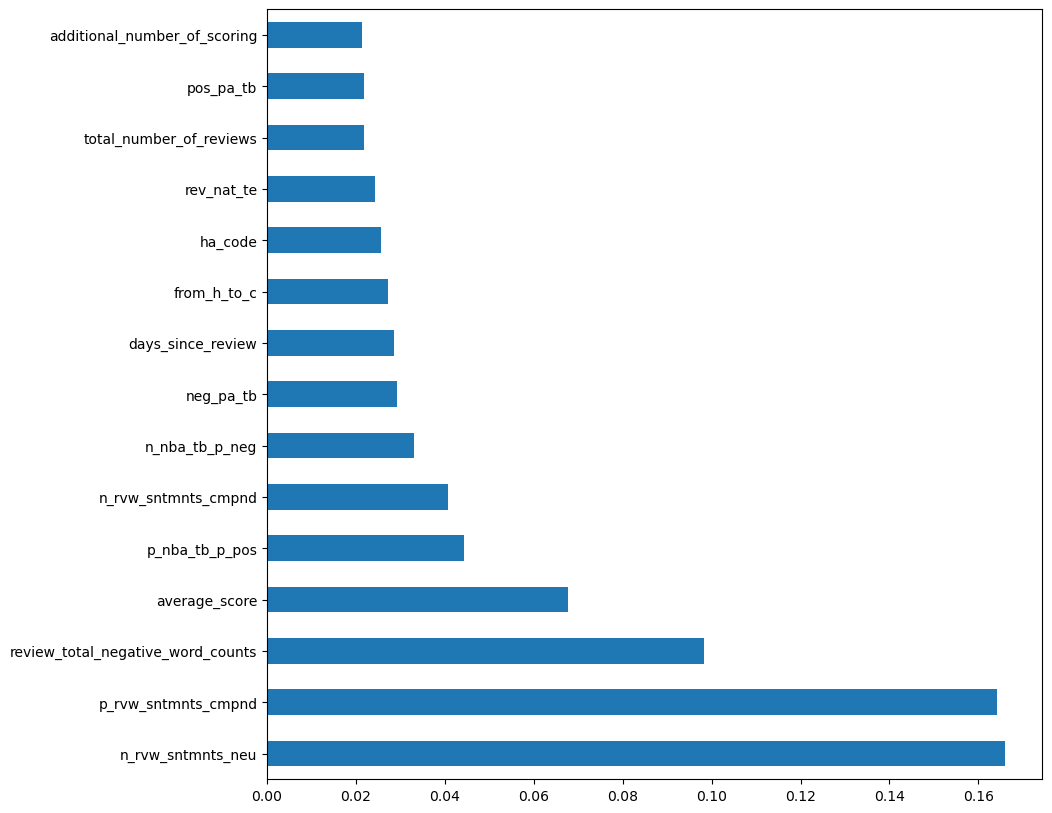

In [72]:
# Выведем самые важные признаки для модели.
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model_RFR.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

<a id = '4.2'></a>
<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

## 4.2 LightGBM

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

LightGBM — это фреймворк, который предоставляет реализацию деревьев принятия решений с градиентным бустингом. Он создан группой исследователей и разработчиков Microsoft. LightGBM известен своей более высокой скоростью обучения, хорошей точностью с параметрами по умолчанию, параллельным и GPU обучением, малым использованием памяти и возможностью обработки больших датасетов, которые не всегда помещаются в ней.

In [73]:
# Напишем функцию для подбора параметров модели.
def cv_params(model, param_grid):
    scoring = 'neg_mean_absolute_error'

    opt_params = GridSearchCV(
        estimator=model,          # Модель.
        param_grid=param_grid,    # Параметры.
        scoring=scoring,          # Стратегия валидации.
        cv=5,                     # Количество слоев кросс валидации.
        n_jobs=-1)                # Количество потоков для обучения, -1 = все.

    opt_params.fit(X_train, y_train)
    params = opt_params.best_params_
    best_score = opt_params.best_score_

    print(f'Best score: {round(-best_score, 2)}')
    print(f'Best parameters: {params}\n')

    return params

In [74]:
%%time

# Зададим ряд параметров для поиска оптимума.
lgb_param_grid = {
                'max_depth': [4, 10, 15, -1],               # Максимальная глубина дерева
                'num_leaves': [25, 35, 45],                 # Максимальное кол-во листьев на дереве
                'n_estimators': [41, 100, 250, 500, 600]    # Количетсво деревьев
                }

lgb_clean = lgb.LGBMRegressor(random_state=RANDOM_SEED)
lgb_params = cv_params(lgb_clean, lgb_param_grid)

Best score: 0.83
Best parameters: {'max_depth': 10, 'n_estimators': 600, 'num_leaves': 45}

Wall time: 5min 40s


In [75]:
# Задаем оптимальные параметры.
model_LGBM = lgb.LGBMRegressor(**lgb_params)
# Обучаем.
model_LGBM.fit(X_train, y_train)
# Предсказываем.
y_pred_LGBM = model_LGBM.predict(X_test)

In [76]:
res_LGBM = round(metrics.mean_absolute_percentage_error(y_test, y_pred_LGBM) * 100, 4)
print('Результат MAPE:', res_LGBM)

Результат MAPE: 11.7248


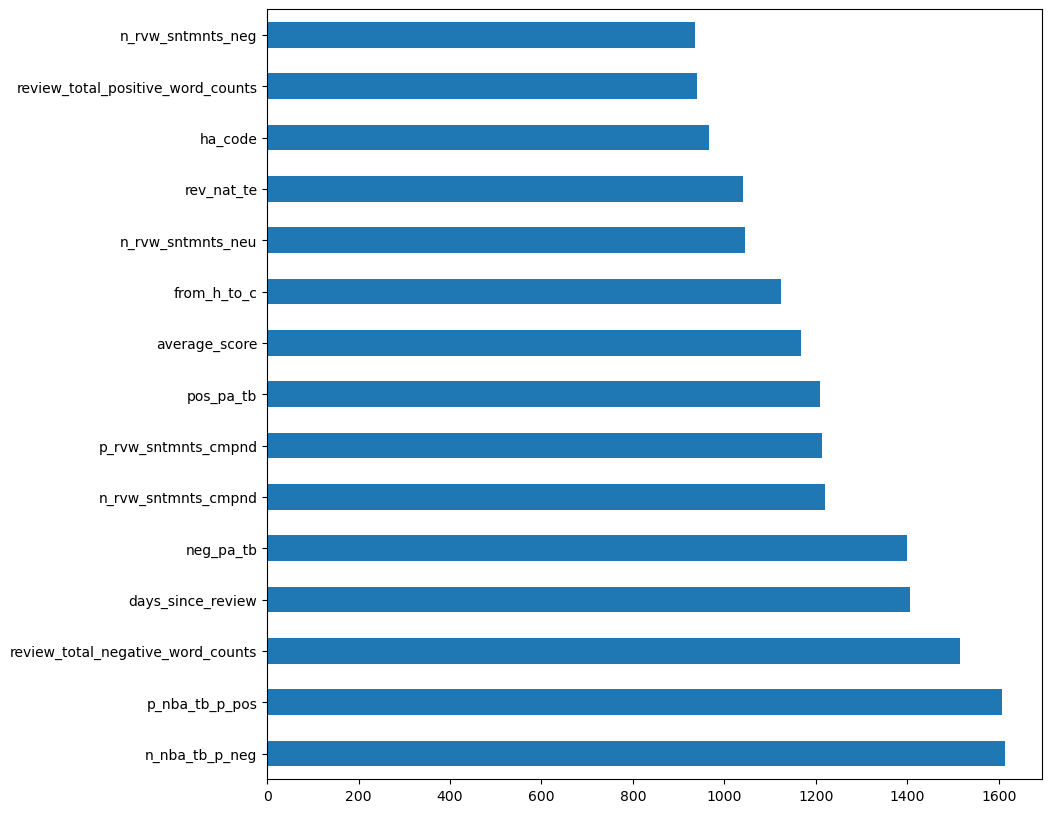

In [77]:
# Выведем самые важные признаки для модели.
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model_LGBM.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

<a id = '4.3'></a>
<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

## 4.3 CatBoostRegressor

</strong></p> 

<a href ="#0">Вернуться к содержанию.</a>

CatBoost — это алгоритм градиентного бустинга на деревьях решений. Он разработан исследователями и инженерами Яндекса и используется для поиска, рекомендательных систем, личного помощника, беспилотных автомобилей, предсказания погоды и многих других задач в Яндексе и других компаниях, включая CERN, Cloudflare, Careem Taxi. Он находится в открытом доступе и может быть использован кем угодно.

In [78]:
model_CBR = CatBoostRegressor(iterations=16000, learning_rate=.1, depth=3, devices='0:1', silent = True)

In [79]:
%%time

# Обучаем.
model_CBR.fit(X_train, y_train)
# Предсказываем.
y_pred_CBR = model_CBR.predict(X_test)

Wall time: 2min 16s


In [80]:
res_CBR = round(metrics.mean_absolute_percentage_error(y_test, y_pred_CBR) * 100, 4)
print('Результат MAPE:', res_CBR)

Результат MAPE: 11.692


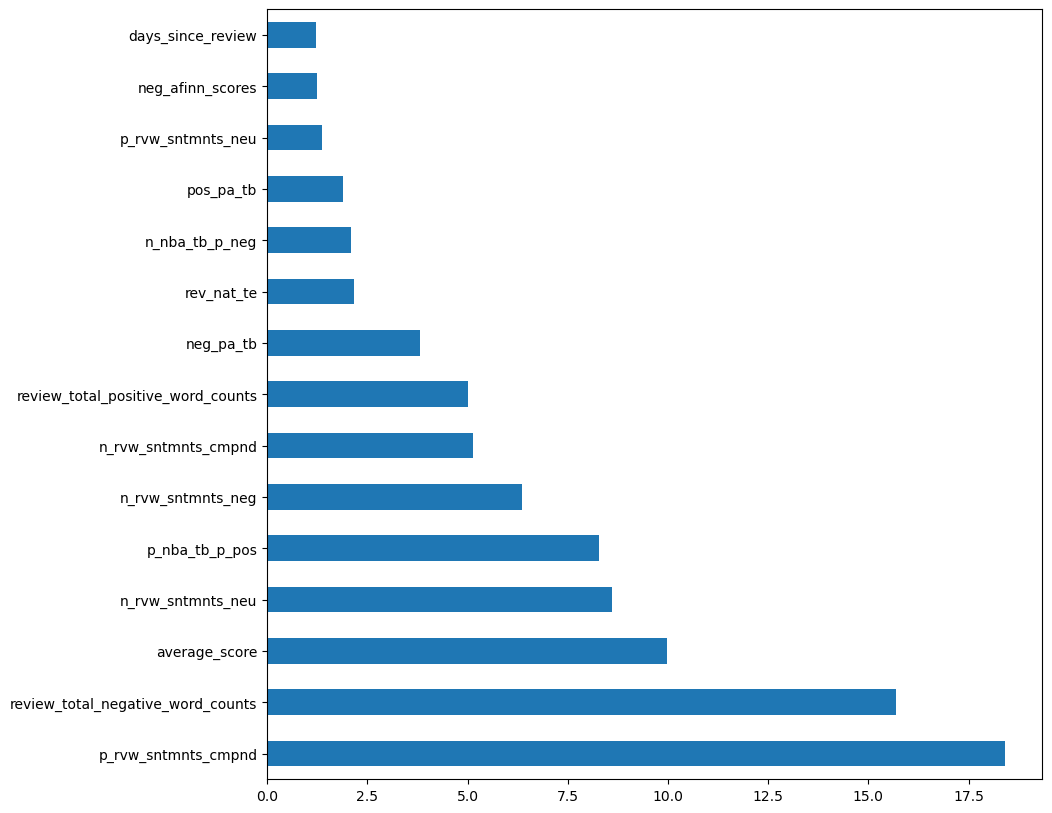

In [81]:
# Выведем самые важные признаки для модели.
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model_CBR.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

<a id = '5'></a>

<p style = "background-color : DodgerBlue; border-radius: 5px 5px; padding : 10px"><strong>

# 5. Финал

</strong></p>

<a href ="#0">Вернуться к содержанию.</a>

Итак, мы обучили наши модели. Лучший результат получился при использовании алгоритма CatBoostRegressor - его-то мы и запустим на тестовых данных.

In [82]:
# Подготовим тестовый датасет.
test_rvws.drop(['reviewer_score'], axis=1, inplace=True)

In [83]:
# Получим предсказания для тестовых данных.
predict_submission = model_CBR.predict(test_rvws)

In [84]:
# Запишем результат в сабмишн файл.
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index = False)
sample_submission.head(10)

,reviewer_score,id
0,8.476194,488440
1,7.862979,274649
2,8.238032,374688
3,9.620773,404352
4,9.480470,451596
5,8.942341,302161
6,8.073662,317079
7,7.559509,13963
8,8.581006,159785
9,7.086096,195089


И здесь наша работа заканчивается. Признаюсь честно, данный труд является во многом собранием заимствований из прочих аналогичных работ. В процессе творения, который длился две недели, я увидел много интересных решений и методов представления, отбора и исследования данных, часть из которых можно было увидеть здесь.

Kaggle удивительная платформа: при честном использовании она помогает набраться опыта и знаний (я правда приобрел для себя здесь много нового); но также способна обречь на тяжкие страдания: когда видишь, что кто-то другой приложил кучу усилий, потратил много времени и получил весьма хороший результат, начинаешь переживать, сумеешь ли приблизиться к такому же качеству, не нарушая профессиональную этику, ведь также важно уметь эффективно употребить имеющееся в наличии время. Я не сорвался и не скопировал чужую работу от и до - иначе какой смысл что-либо делать? А за заимствования попытаюсь оправдаться тем, что действительно учился у лучших в нашем соревновании, и постарался изучить, зачем они делали то, что делали. Впервые выполняя такую работу, я стремился соблюдать положенный порядок, и у меня, хоть и не безупречное, но что-то все же получилось. Да, со стороны это, возможно, лишь очередной чей-то маленький шажок в мир Data Science, но для меня же он действительно большой. Надеюсь, это и есть начало моего долгого путешествия (: